In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from typing import OrderedDict
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2 as fasterrcnn_resnet50_fpn
import nltk
nltk.download('punkt_tab')

# Add parent directory to the system path
script_dir = os.path.dirname(os.path.abspath(""))
sys.path.append(os.path.dirname(script_dir))

from data.dataset import FlickrDataset, collate_fn, get_transform
from data.preprocessing import (
    build_vocabulary,
    convert_captions_to_sequences,
    get_splits,
    prepare_image2captions,
)
import pandas as pd

dataset = "Flickr8k"
dataset_dir = f"../../flickr_data/{dataset}_Dataset/Images"
captions_file = f"../../flickr_data/{dataset}_Dataset/captions.txt"
image_dir = dataset_dir

# Load captions
caption_df = pd.read_csv(captions_file).dropna().drop_duplicates()
print(f"Total captions loaded: {len(caption_df)}")

# Build vocabulary
word2idx, idx2word, image_captions = build_vocabulary(caption_df, vocab_size=5000)
print(f"Vocabulary size: {len(word2idx)}")

# Convert captions to sequences
captions_seqs, max_length = convert_captions_to_sequences(image_captions, word2idx)
print(f"Maximum caption length: {max_length}")

image_names = list(image_captions.keys())
train_images, val_images, _ = get_splits(image_names, test_size=0.3)
image_names = list(image_captions.keys())

train_transform = get_transform(train=True)
# Create datasets and data loaders
train_dataset = FlickrDataset(
    image_dir, train_images, captions_seqs, transform=train_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
)

model = fasterrcnn_resnet50_fpn(weights="COCO_V1")
model.eval()
backbone = model.backbone
rpn = model.rpn
roi_heads = model.roi_heads
transform = model.transform

/opt/miniconda3/envs/image-captioning-project/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ivankoh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ivankoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total captions loaded: 40445
Vocabulary size: 5000
Maximum caption length: 40


In [2]:
images = next(iter(train_loader))
# extract 1 batch and flatten the batch dimension
images = images[0]

with torch.no_grad(): 
    transformed_images, _ = transform(images)
    features = backbone(transformed_images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    proposals, _ = rpn(transformed_images, features, None)
    detections, _ = roi_heads(features, proposals, transformed_images.image_sizes, None)

box_features = roi_heads.box_roi_pool(
    features, proposals, transformed_images.image_sizes
)
box_features = roi_heads.box_head(box_features)  # the bottom up features

class_logits, box_regression = roi_heads.box_predictor(box_features)
boxes, scores, labels = roi_heads.postprocess_detections(
    class_logits, box_regression, proposals, transformed_images.image_sizes
)

# sanity check to make sure we are getting the bottom up features correctly
for i, d in enumerate(detections):
    box = d["boxes"]
    score = d["scores"]
    label = d["labels"]
    assert torch.allclose(boxes[i], box), "The boxes are not the same"
    assert torch.allclose(scores[i], score), "The scores are not the same"
    assert torch.allclose(labels[i], label), "The labels are not the same"

print("All tests passed!")

batch_size = len(images)
print(f"batch size: {batch_size}")
original_image_sizes = [(256,256)] * batch_size
detections = transform.postprocess(detections, transformed_images.image_sizes, original_image_sizes)

All tests passed!
batch size: 32


image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (100.32068, 31.258512, 108.09877, 49.586304)
box coordinates: (197.4139, 94.248055, 221.90562, 122.169205)
box coordinates: (177.57494, 52.77677, 183.68365, 67.92371)
box coordinates: (226.57896, 55.312466, 232.082, 66.49341)
box coordinates: (198.30336, 55.001328, 203.67793, 64.87834)
box coordinates: (197.47638, 92.051094, 255.34282, 123.622086)
box coordinates: (136.26262, 54.80556, 145.1976, 71.74227)
box coordinates: (157.14124, 81.70797, 163.87555, 115.54619)
box coordinates: (4.111851, 65.583565, 10.640281, 74.366615)
box coordinates: (244.84871, 50.908806, 250.51292, 60.504772)
box coordinates: (20.227085, 68.436325, 26.695326, 82.09362)
box coordinates: (127.70787, 51.95435, 133.55884, 64.794914)
box coordinates: (156.47081, 80.059494, 174.0145, 120.009415)
box coordinates: (161.22543, 52.707645, 169.20633, 63.518047)
box coordinates: (170.30382, 51.970474, 183.

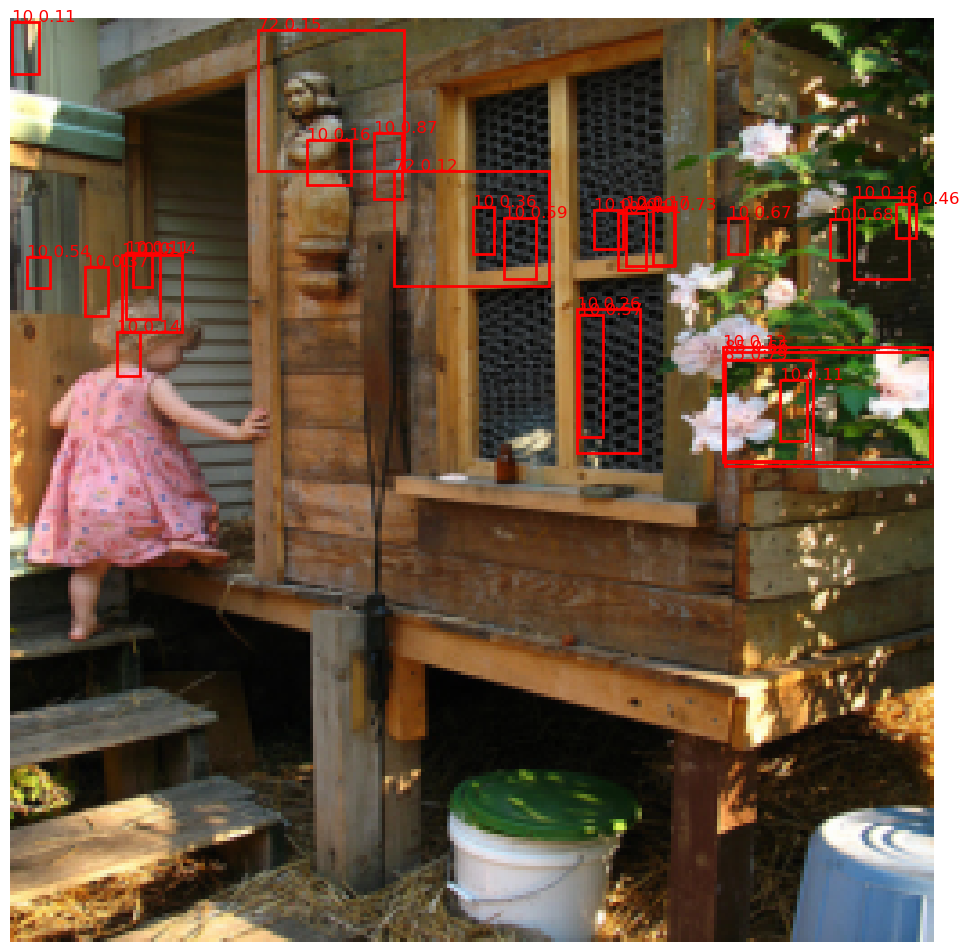

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (137.91722, 90.5172, 164.44391, 114.39256)
box coordinates: (137.07983, 105.24045, 141.95276, 114.98691)
box coordinates: (157.56169, 90.21156, 164.01027, 102.158745)
box coordinates: (64.51371, 0.0, 256.0, 170.35281)
box coordinates: (131.68709, 104.563194, 140.80917, 130.4903)
box coordinates: (62.847378, 207.5717, 69.87957, 216.22865)
box coordinates: (127.528946, 107.588844, 139.20999, 137.67754)


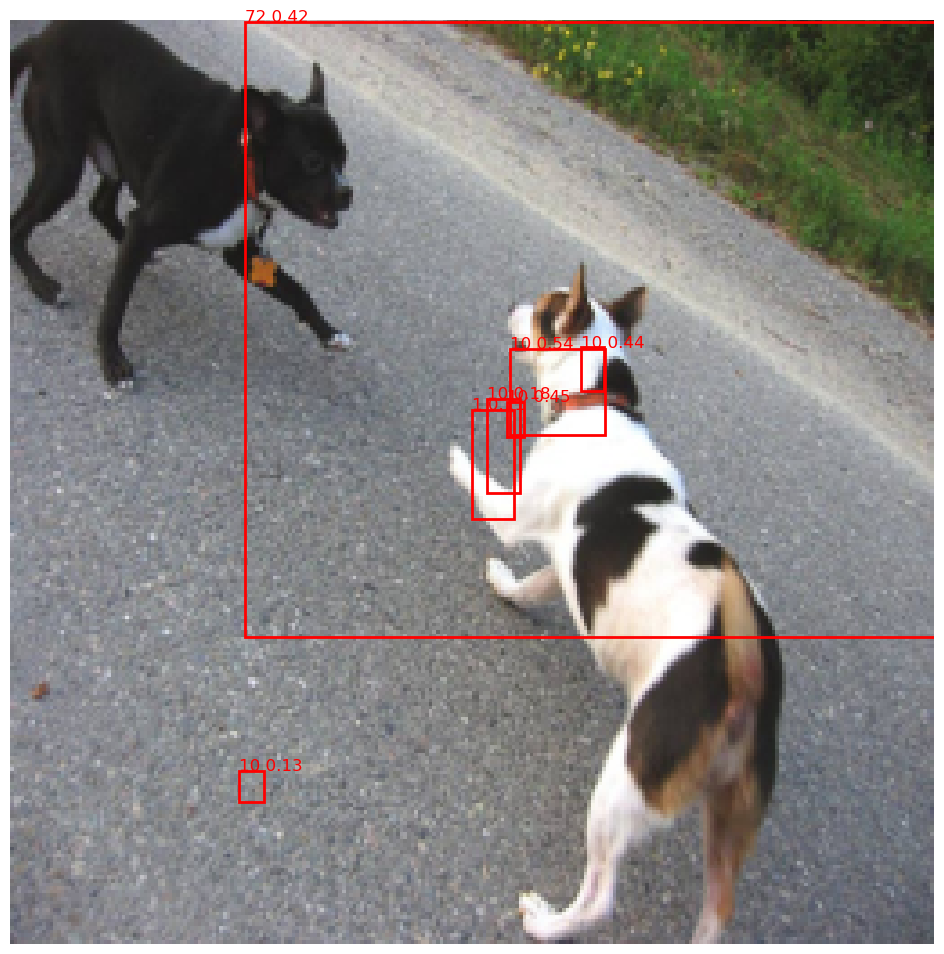

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (4.4606805, 0.0, 18.95563, 52.657665)
box coordinates: (93.51141, 83.362755, 113.67034, 105.41365)
box coordinates: (84.205795, 7.9996896, 152.72583, 64.454185)
box coordinates: (147.42302, 140.6068, 156.23898, 148.83)
box coordinates: (81.10505, 3.7709837, 190.3086, 70.1376)
box coordinates: (24.866302, 0.7157812, 34.793793, 22.972229)
box coordinates: (103.81995, 91.767235, 114.50866, 104.414345)
box coordinates: (93.35129, 84.94277, 105.41443, 103.53697)
box coordinates: (5.1173697, 38.87886, 16.881557, 54.643837)
box coordinates: (158.98329, 152.10773, 172.42975, 169.10191)


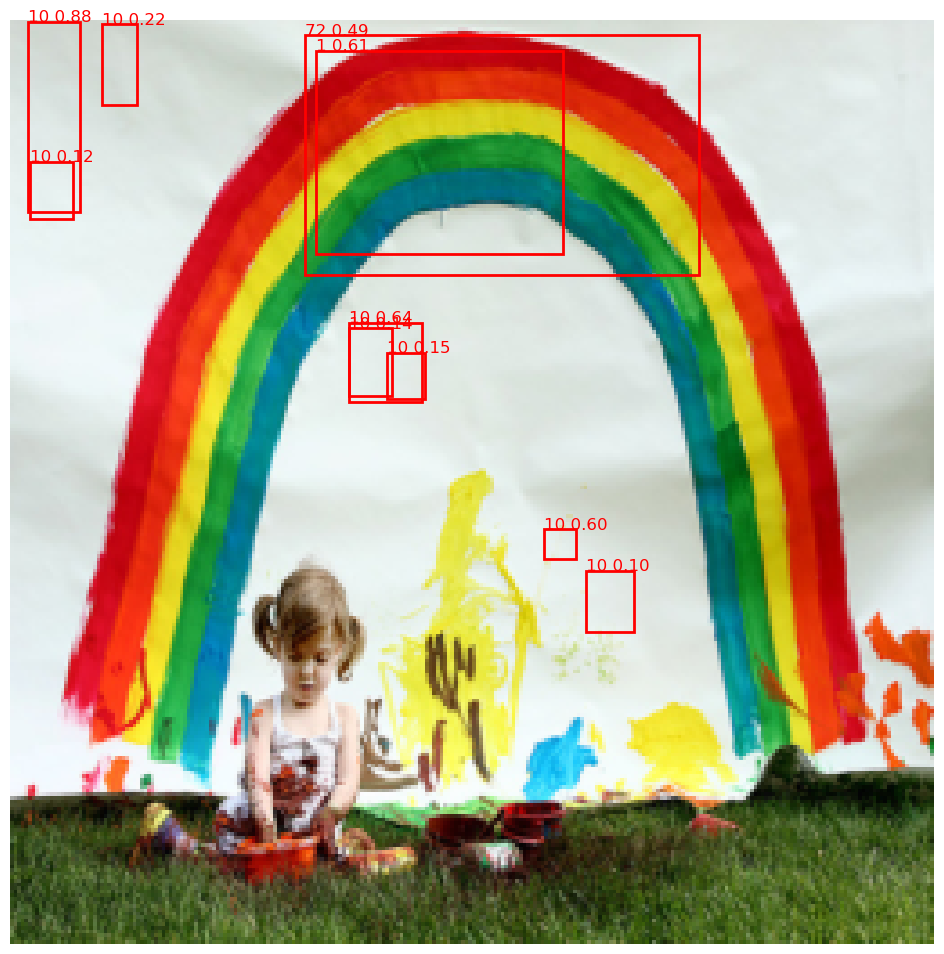

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (84.36148, 238.11977, 104.00049, 247.9641)
box coordinates: (175.95885, 93.766846, 184.06908, 112.13471)
box coordinates: (129.77386, 51.28115, 158.76503, 87.213356)
box coordinates: (96.27698, 149.75082, 104.79241, 159.72824)
box coordinates: (40.85797, 151.87985, 48.766727, 160.05243)
box coordinates: (20.662998, 219.16727, 25.754282, 224.36386)
box coordinates: (21.680628, 216.77588, 26.967873, 221.96213)
box coordinates: (47.674183, 134.42488, 102.71273, 179.73927)


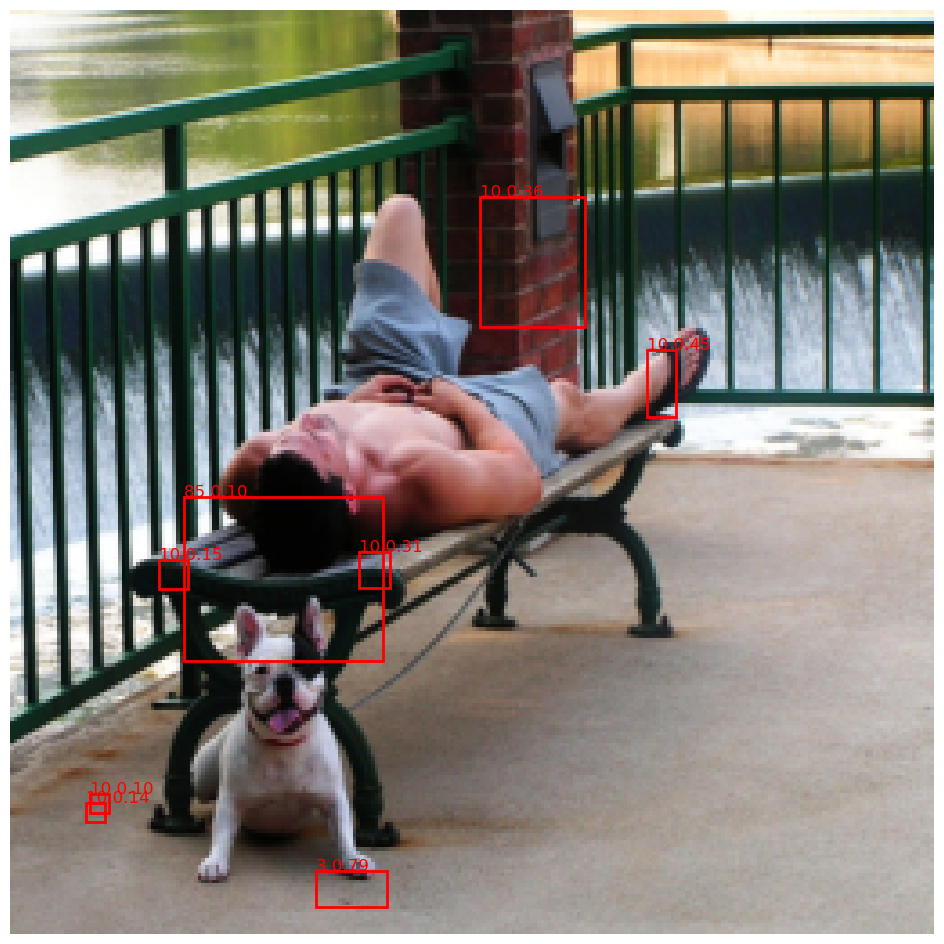

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (125.75084, 159.30142, 134.33469, 169.56767)
box coordinates: (86.470245, 72.62005, 166.0261, 171.57262)
box coordinates: (92.35844, 160.56369, 105.90093, 170.62514)
box coordinates: (192.15582, 20.756239, 226.33199, 112.490456)
box coordinates: (93.92832, 160.57295, 105.151855, 170.39204)
box coordinates: (84.89764, 74.8122, 163.7975, 176.64899)


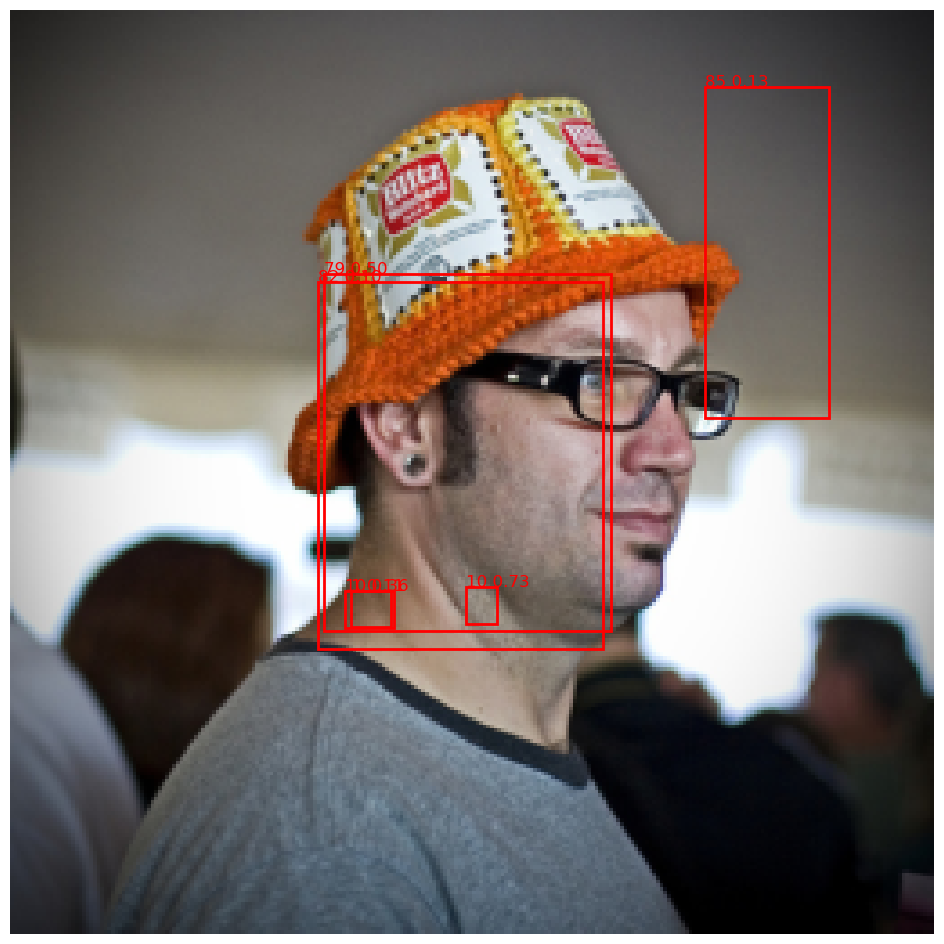

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (117.453835, 93.72629, 126.00598, 98.76451)


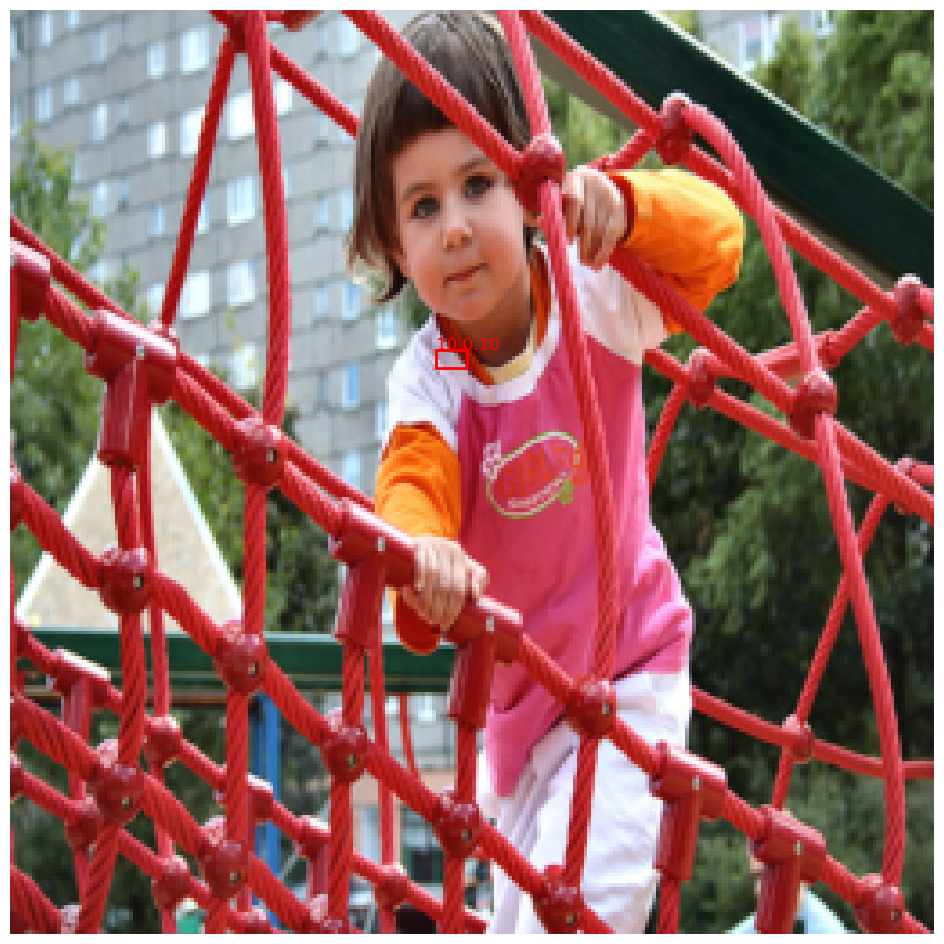

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (95.29926, 143.17172, 174.75732, 197.77664)
box coordinates: (75.77176, 72.137436, 119.44361, 100.97909)
box coordinates: (211.4707, 61.3566, 237.01883, 84.05511)
box coordinates: (15.388268, 113.39695, 25.70837, 125.64964)
box coordinates: (61.647808, 196.09166, 67.09123, 202.21135)
box coordinates: (44.93375, 181.73712, 52.01702, 194.08904)
box coordinates: (39.373425, 38.547634, 114.25112, 73.51891)
box coordinates: (67.49125, 29.836357, 224.67136, 203.91164)
box coordinates: (156.78331, 116.98121, 174.9634, 145.23277)


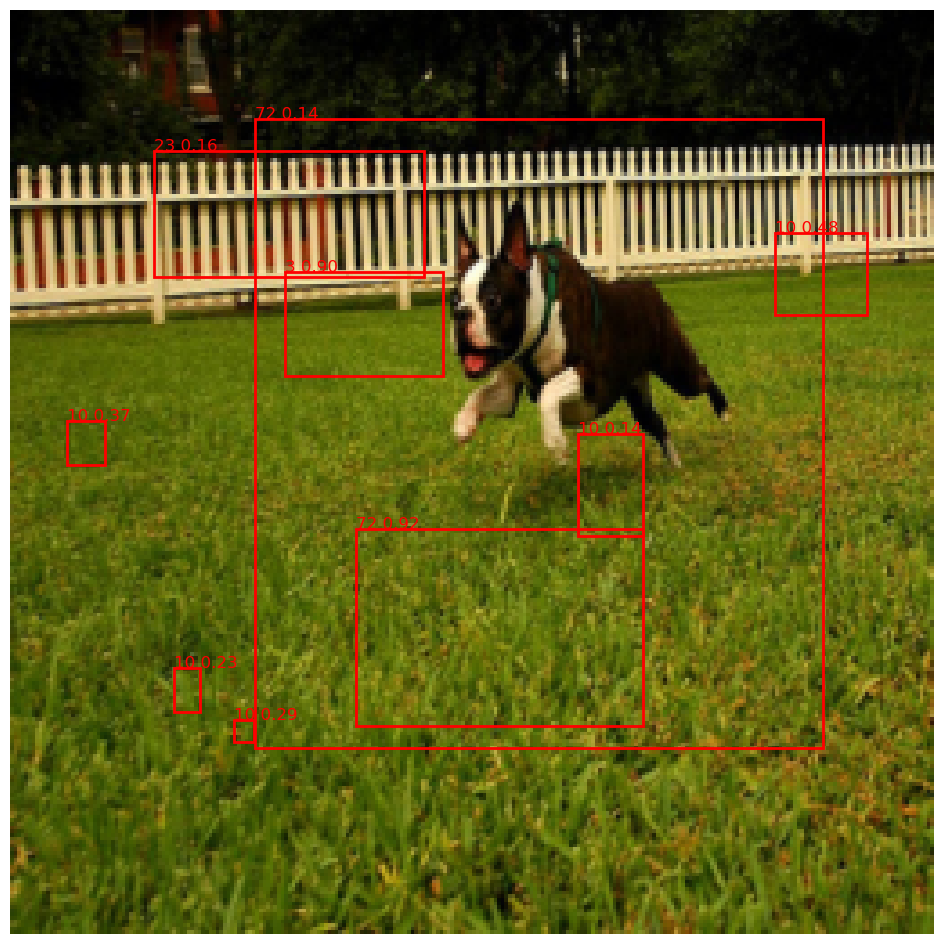

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (146.29813, 114.45854, 151.81256, 120.09382)
box coordinates: (176.00111, 138.63483, 187.39775, 161.34773)
box coordinates: (150.03111, 95.86696, 161.13284, 113.05069)
box coordinates: (175.28831, 136.07155, 191.90941, 182.08908)
box coordinates: (148.6957, 97.60615, 164.2957, 120.24091)
box coordinates: (162.95612, 157.65948, 175.83797, 182.53114)
box coordinates: (60.75994, 114.10192, 94.4928, 148.22435)


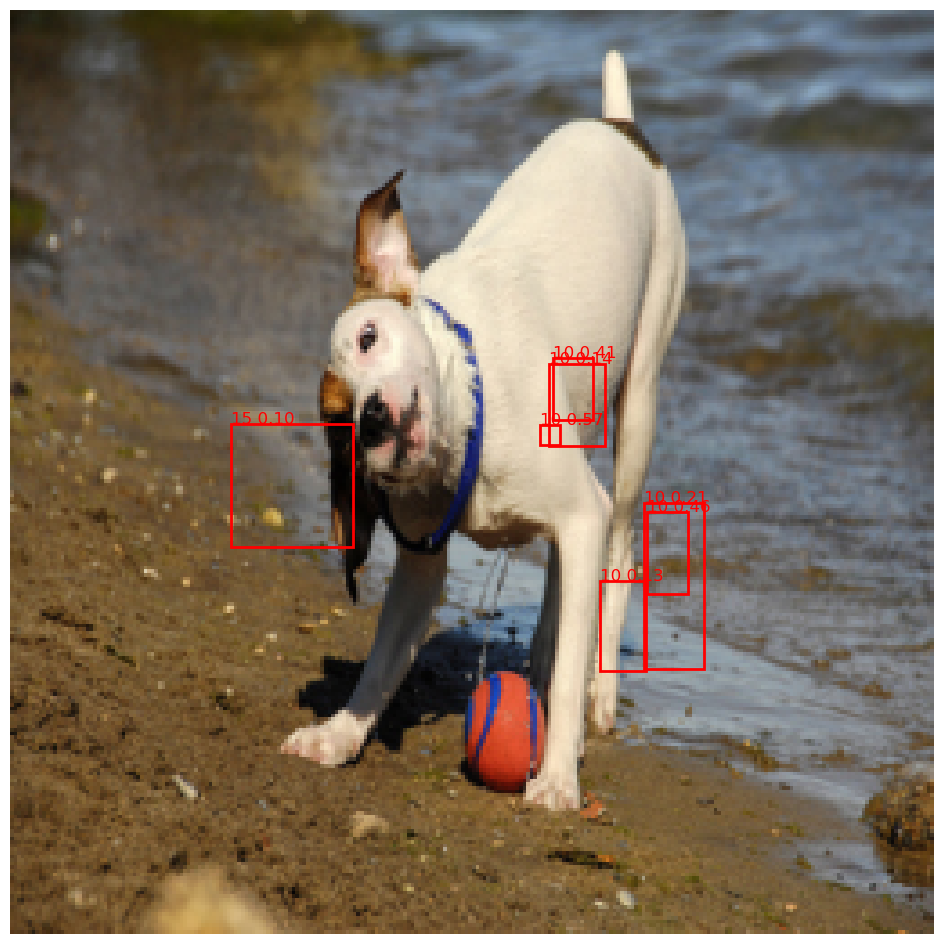

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (65.841545, 9.03316, 73.4398, 33.87117)
box coordinates: (126.13299, 27.284643, 135.32558, 48.896317)
box coordinates: (198.61198, 0.15235656, 206.98749, 10.551084)
box coordinates: (184.34775, 168.25789, 191.43677, 187.81844)
box coordinates: (175.87375, 214.2868, 183.30807, 221.9713)
box coordinates: (81.26727, 227.54169, 104.84659, 241.5986)
box coordinates: (208.93275, 223.57173, 235.50157, 235.20407)
box coordinates: (60.147938, 232.64832, 78.976494, 247.81754)
box coordinates: (0.91148925, 247.50108, 45.372185, 256.0)
box coordinates: (149.07872, 14.089802, 155.77737, 28.625183)
box coordinates: (42.610306, 251.84467, 74.57814, 255.85786)
box coordinates: (233.08647, 205.5882, 255.66304, 228.91324)
box coordinates: (171.08238, 20.479794, 177.68813, 38.626484)
box coordinates: (207.6919, 205.2608, 255.78564, 229.23302)
box coordinates: (101.74039, 169.52554, 130.824

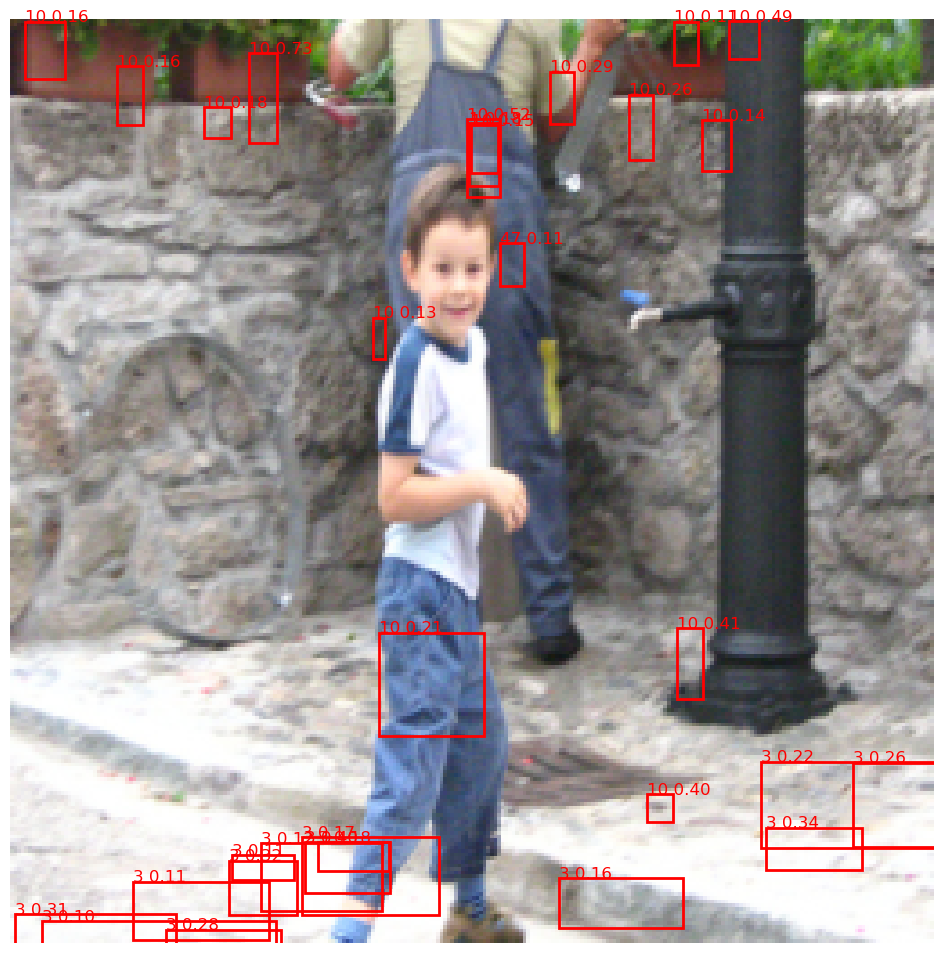

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (235.43645, 25.713783, 239.96402, 35.602535)
box coordinates: (212.29836, 43.47466, 222.2607, 58.28411)
box coordinates: (234.34766, 46.046707, 240.84456, 65.006)
box coordinates: (126.71915, 216.3326, 135.95193, 233.5638)
box coordinates: (12.463559, 229.97566, 19.608412, 248.09167)


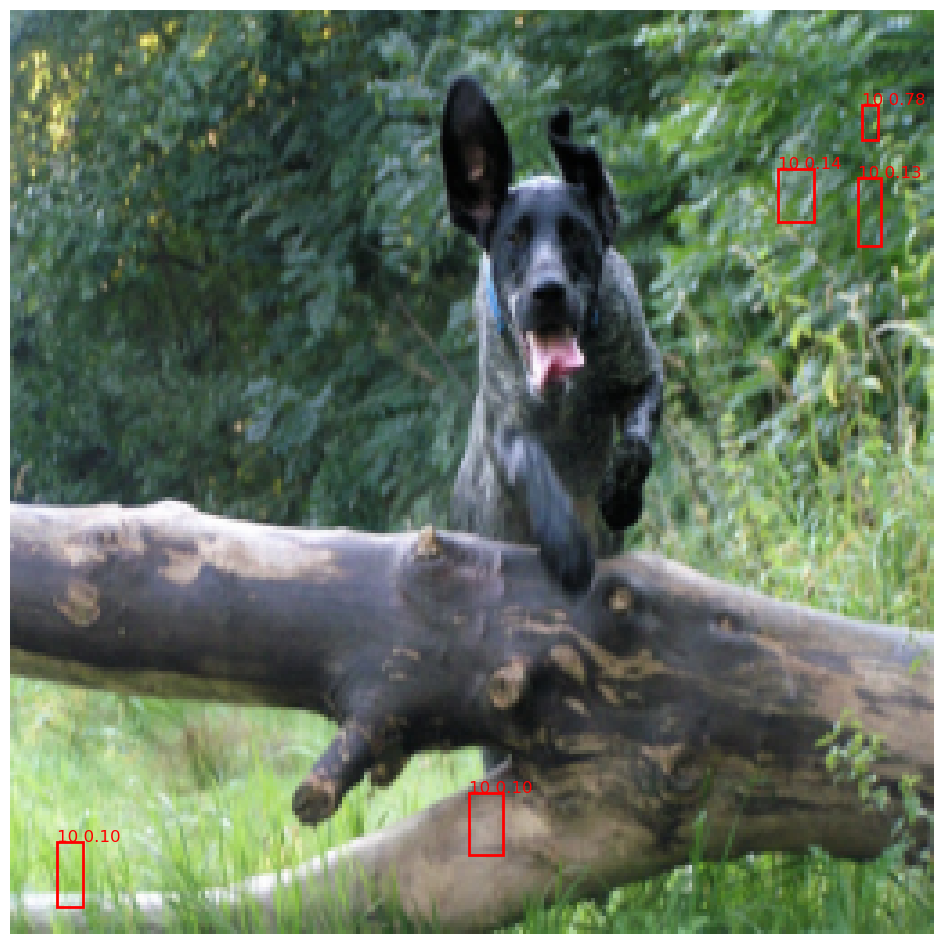

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (201.6447, 53.6757, 208.73975, 71.520836)
box coordinates: (201.97784, 53.503193, 208.60707, 71.308136)
box coordinates: (140.28496, 8.209025, 169.66336, 29.700253)


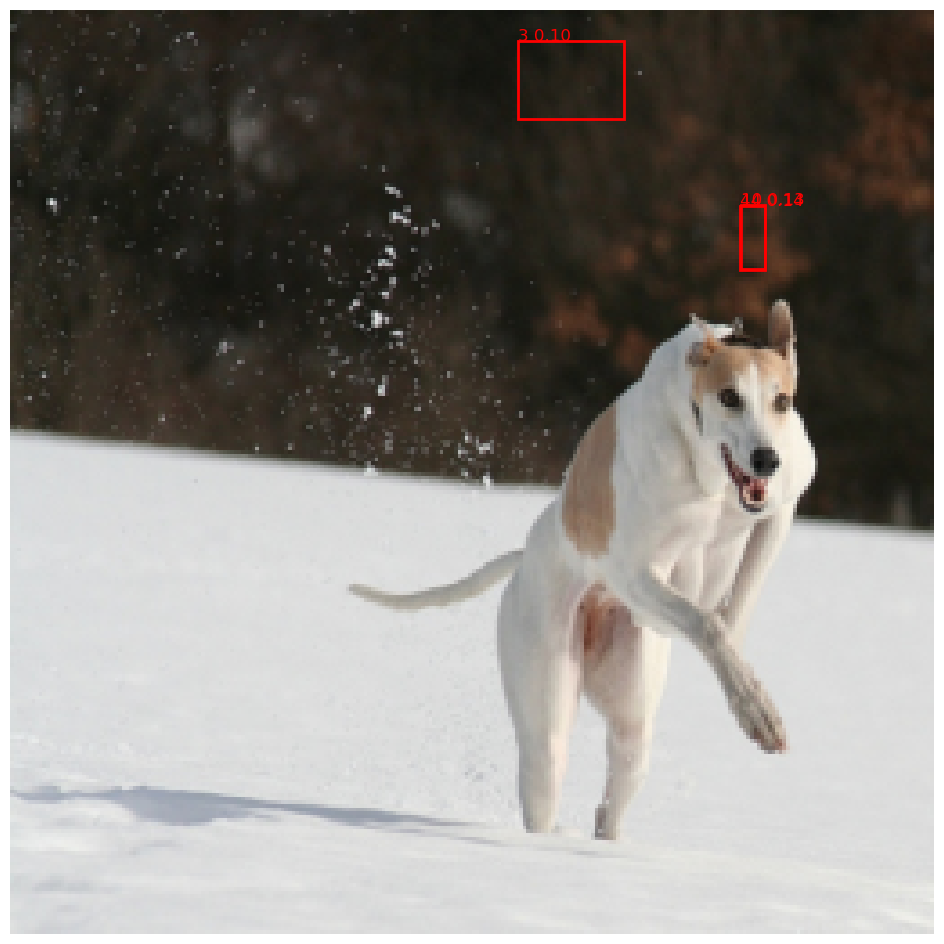

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (56.422176, 95.62727, 66.73469, 111.43936)
box coordinates: (27.198524, 78.429306, 32.74571, 96.02404)
box coordinates: (45.62072, 93.17292, 55.105175, 105.907074)
box coordinates: (48.930794, 93.32803, 66.44758, 111.89905)
box coordinates: (57.74256, 124.30205, 67.512955, 129.23848)
box coordinates: (23.382814, 77.534874, 33.299744, 100.677734)
box coordinates: (25.413235, 101.7738, 46.766933, 137.5485)
box coordinates: (83.14454, 90.37289, 90.7785, 109.49855)
box coordinates: (17.600613, 168.71982, 41.817566, 182.83192)
box coordinates: (57.2654, 120.90707, 68.88784, 129.91707)


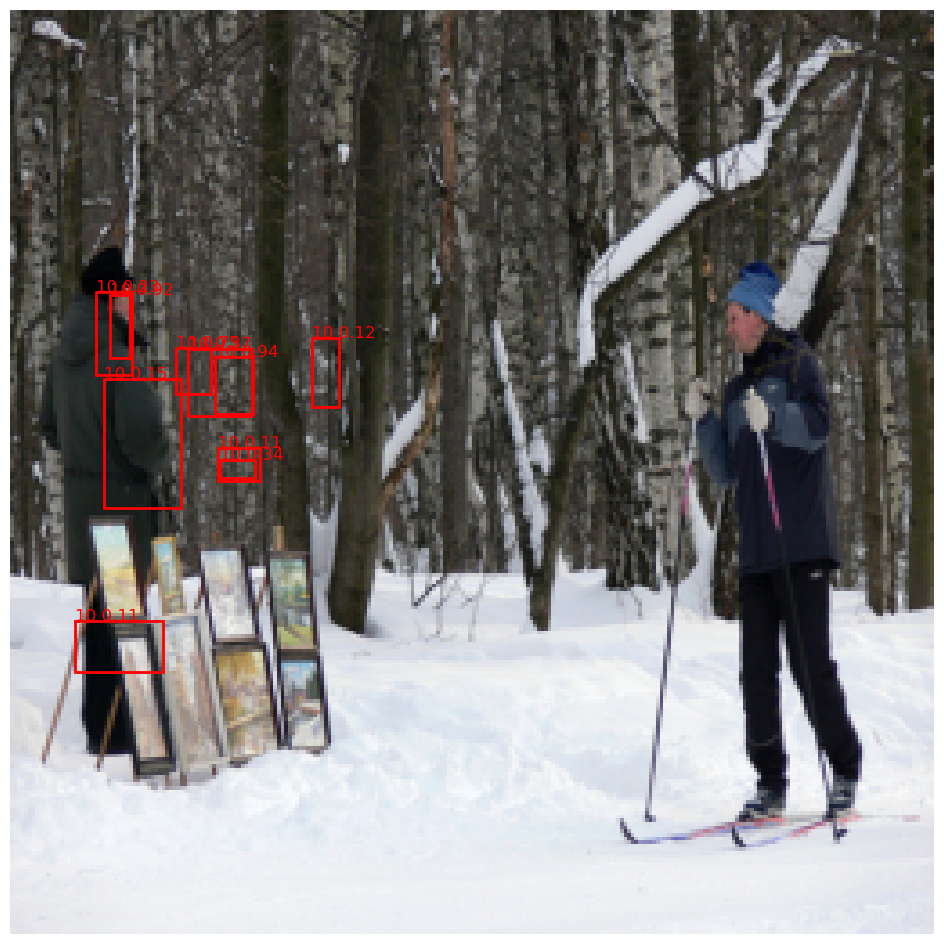

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (49.66077, 248.03456, 60.06294, 256.0)


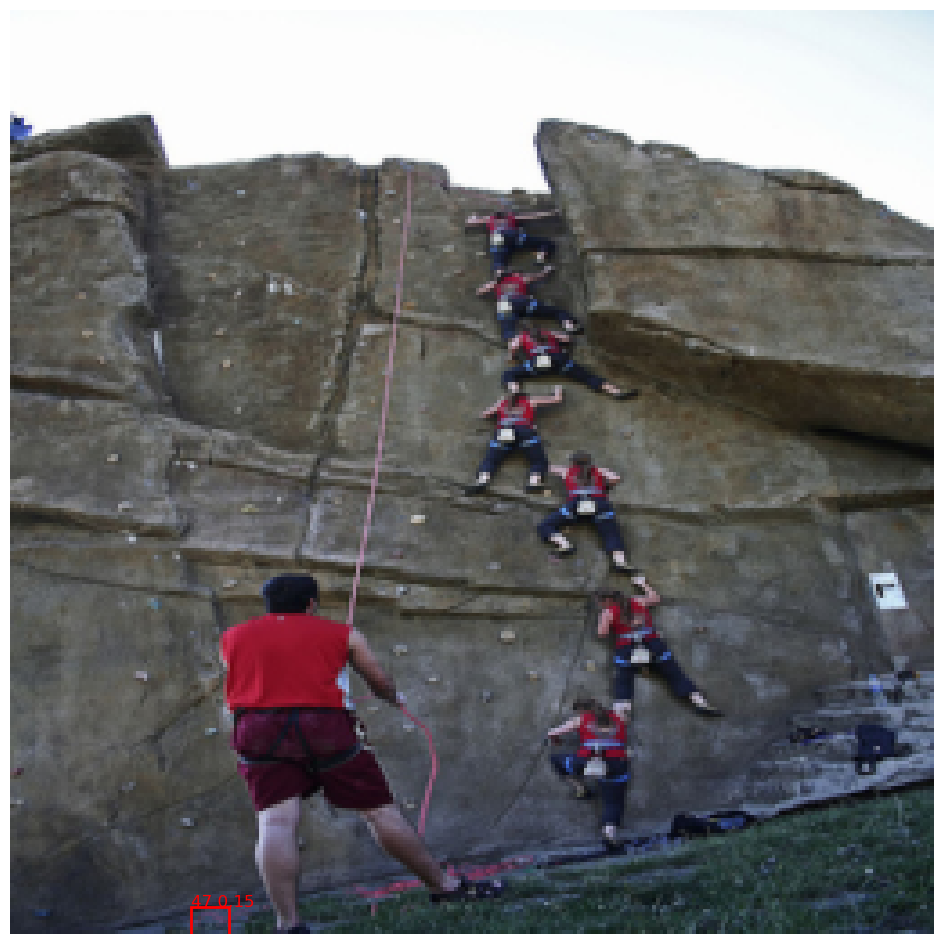

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (79.55062, 229.00371, 96.02383, 255.38562)
box coordinates: (114.494835, 121.666794, 121.93563, 126.4064)
box coordinates: (121.85666, 126.32122, 127.433105, 133.54414)
box coordinates: (69.93962, 121.00238, 108.699356, 150.7964)
box coordinates: (81.49224, 229.1822, 91.16424, 245.85576)


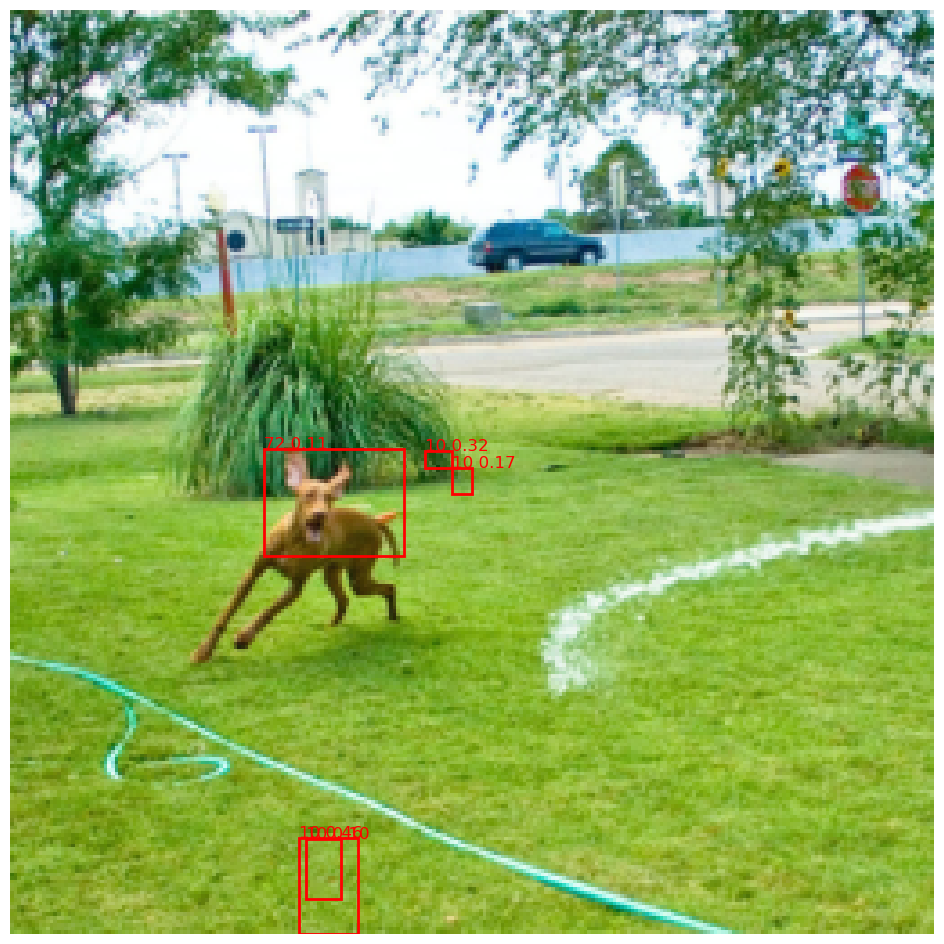

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (239.6746, 136.30276, 255.936, 219.57207)
box coordinates: (35.95368, 165.2558, 52.943874, 208.92424)
box coordinates: (243.27908, 141.6733, 256.0, 183.19275)
box coordinates: (118.451744, 189.98727, 144.7336, 211.26904)
box coordinates: (98.31998, 218.40823, 108.41351, 248.46317)
box coordinates: (134.62135, 162.11893, 143.2314, 180.5658)
box coordinates: (209.35606, 180.27896, 225.17017, 215.13087)


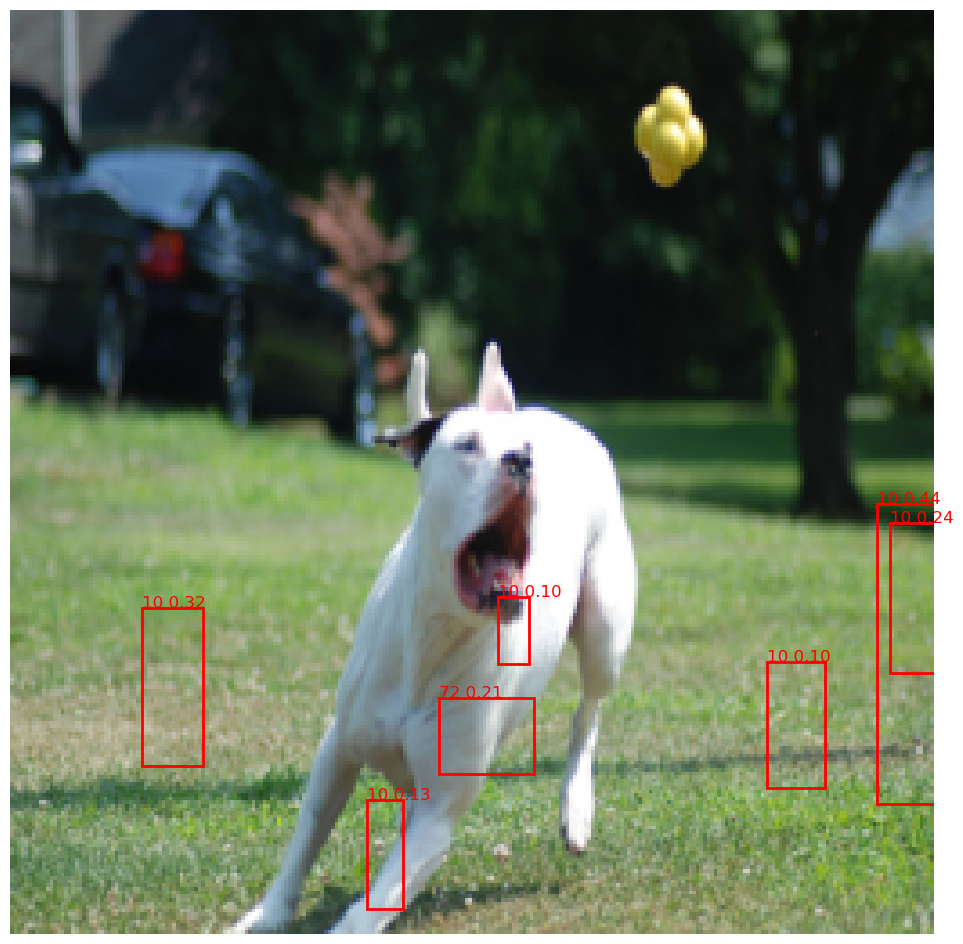

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (188.8086, 125.64558, 195.01117, 137.46866)
box coordinates: (152.45163, 40.34297, 162.81725, 70.873566)
box coordinates: (189.65831, 46.279556, 197.88051, 76.72598)
box coordinates: (144.97913, 66.721, 149.8314, 78.23959)
box coordinates: (207.9272, 4.322677, 218.7417, 38.56466)
box coordinates: (211.10394, 47.802143, 218.07565, 59.279594)
box coordinates: (222.76347, 26.088251, 227.37886, 36.716343)
box coordinates: (245.71257, 13.502399, 250.71918, 22.932085)


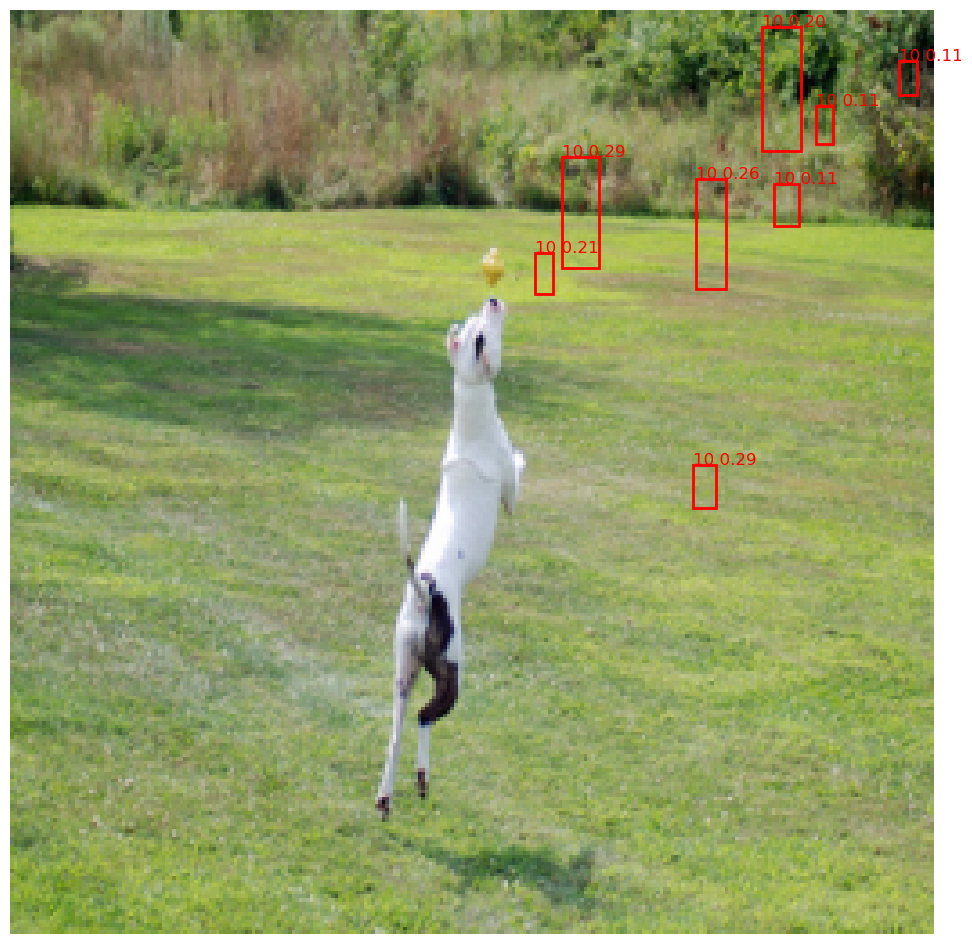

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (88.67161, 23.409609, 135.95113, 200.00397)
box coordinates: (167.85979, 179.16666, 177.08783, 189.41803)
box coordinates: (66.02093, 177.54816, 71.68762, 185.07452)
box coordinates: (148.90851, 151.01837, 153.47816, 160.6885)
box coordinates: (163.25262, 178.66093, 177.3666, 192.54285)
box coordinates: (190.06828, 194.42314, 204.41472, 213.14104)
box coordinates: (186.19398, 163.98885, 222.37836, 209.45158)
box coordinates: (192.25595, 165.10577, 209.39928, 184.70714)


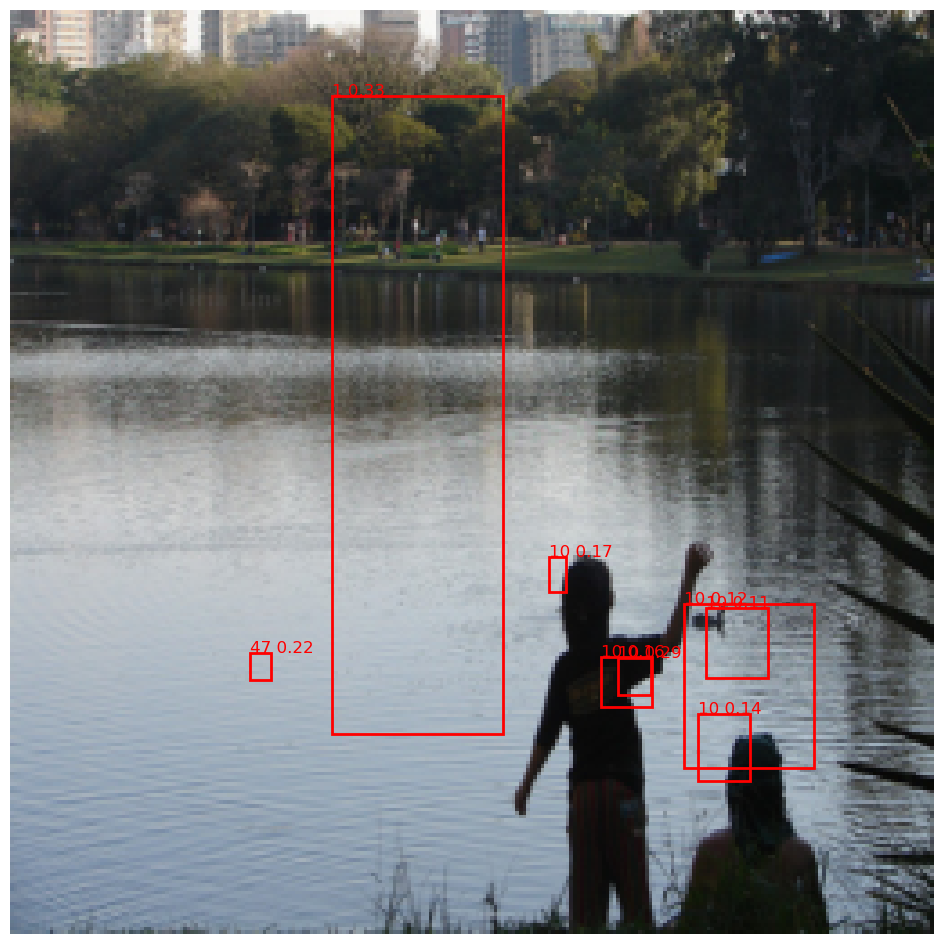

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (163.15198, 144.02252, 185.00331, 183.17169)
box coordinates: (158.62108, 175.949, 199.89015, 252.53986)
box coordinates: (77.389275, 87.236305, 92.189316, 113.28095)
box coordinates: (169.6105, 244.75008, 180.83035, 256.0)
box coordinates: (77.80359, 87.700294, 92.318146, 113.50904)
box coordinates: (172.56226, 138.68198, 186.42726, 156.44165)
box coordinates: (171.05817, 125.721664, 178.1557, 140.01758)
box coordinates: (161.31416, 145.07683, 186.93408, 184.0453)
box coordinates: (79.28458, 89.92526, 87.54995, 99.2831)
box coordinates: (171.09308, 126.22184, 178.12804, 138.6994)
box coordinates: (171.1264, 126.11639, 178.08469, 138.87137)


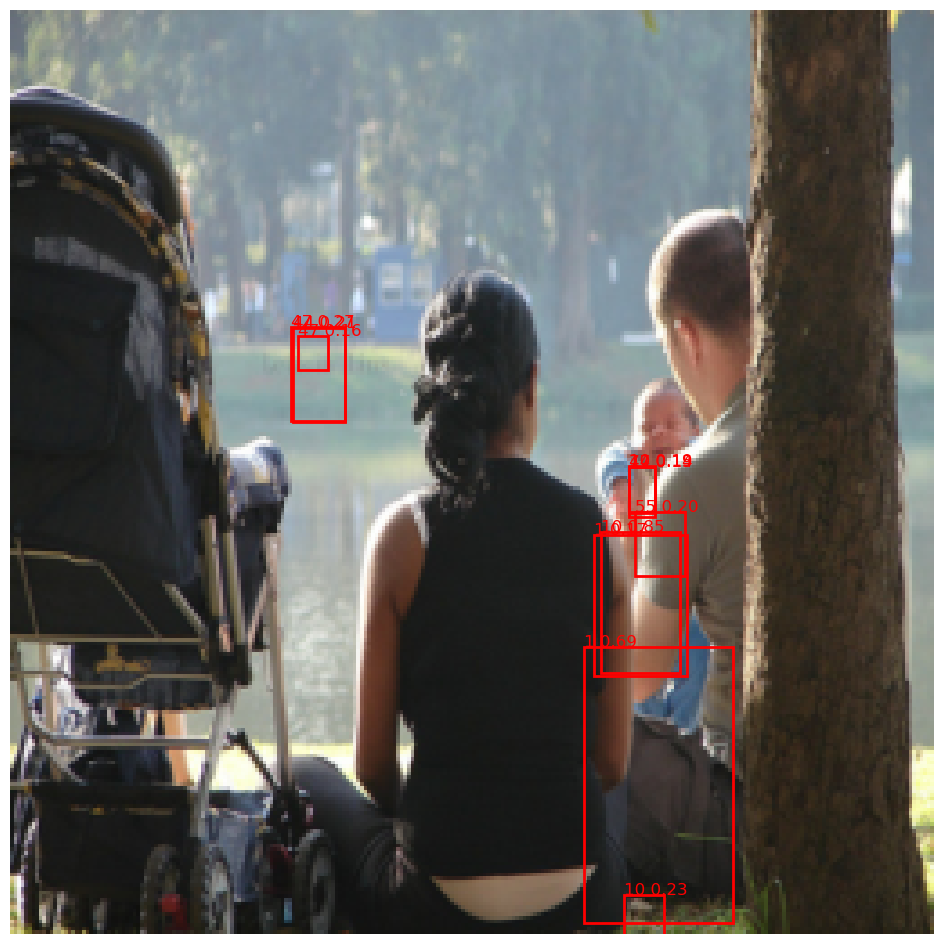

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (1.5060107, 11.691865, 84.85916, 97.89653)


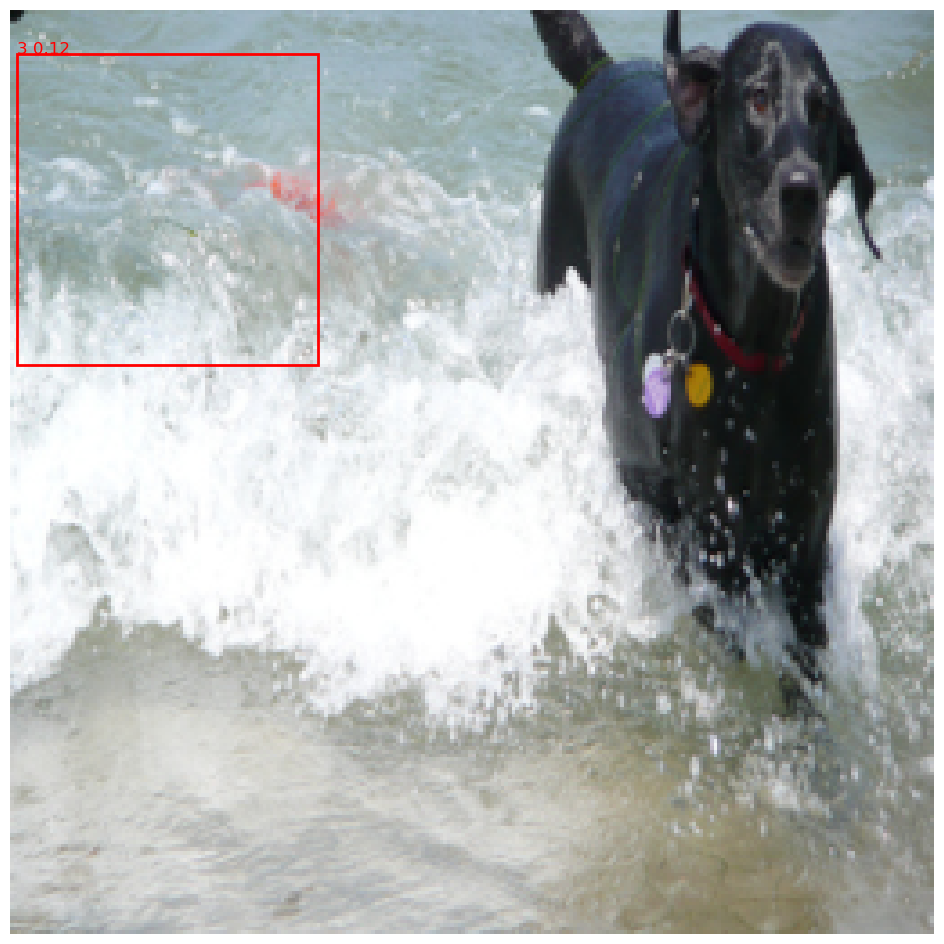

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (157.14082, 139.20174, 167.81418, 155.51321)
box coordinates: (137.88277, 140.84062, 144.12671, 152.5602)
box coordinates: (248.58763, 127.85772, 255.9452, 140.43056)
box coordinates: (188.24748, 107.75127, 195.96185, 122.59056)
box coordinates: (0.4328308, 141.02031, 22.292816, 174.86916)
box coordinates: (236.1597, 110.9664, 250.17099, 119.39224)
box coordinates: (226.1749, 12.1970215, 255.91634, 26.059505)
box coordinates: (31.144823, 103.34649, 51.177948, 115.72233)
box coordinates: (16.555403, 103.23407, 50.3896, 119.876)
box coordinates: (224.98172, 91.184685, 255.17293, 109.12584)
box coordinates: (114.22975, 140.42795, 136.96333, 156.02078)
box coordinates: (6.261521, 90.290924, 52.529743, 117.95973)
box coordinates: (54.78943, 108.71589, 60.12764, 113.32528)
box coordinates: (249.01842, 130.36641, 255.62646, 136.21748)
box coordinates: (189.95636, 107.8351, 196.

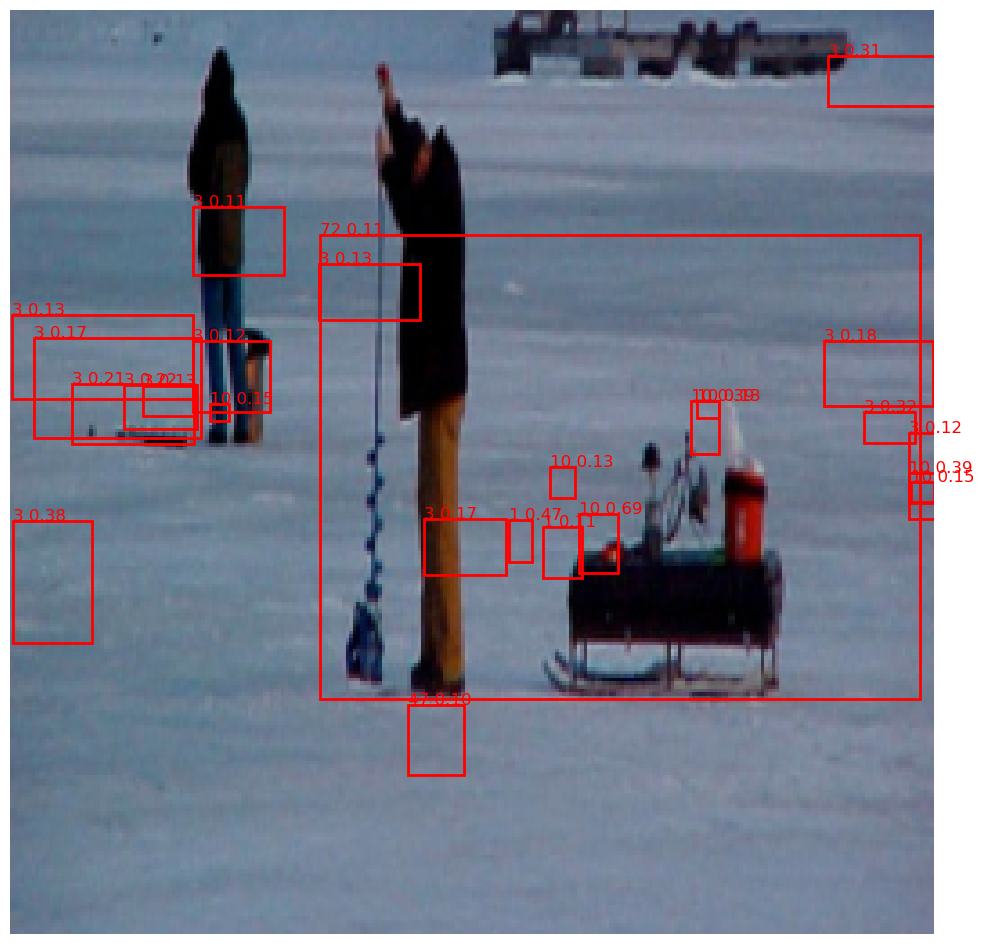

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (179.56926, 0.63366455, 195.53499, 12.526402)
box coordinates: (160.654, 19.045437, 171.95908, 28.356228)
box coordinates: (39.95679, 33.083252, 174.13434, 115.93754)
box coordinates: (242.4256, 108.28084, 255.93927, 132.74962)
box coordinates: (186.43965, 2.9628563, 255.3307, 55.791878)
box coordinates: (193.8984, 0.85274535, 216.03462, 13.060108)
box coordinates: (209.33443, 5.337739, 255.73697, 42.645103)
box coordinates: (179.67767, 0.93053466, 197.7586, 25.515959)


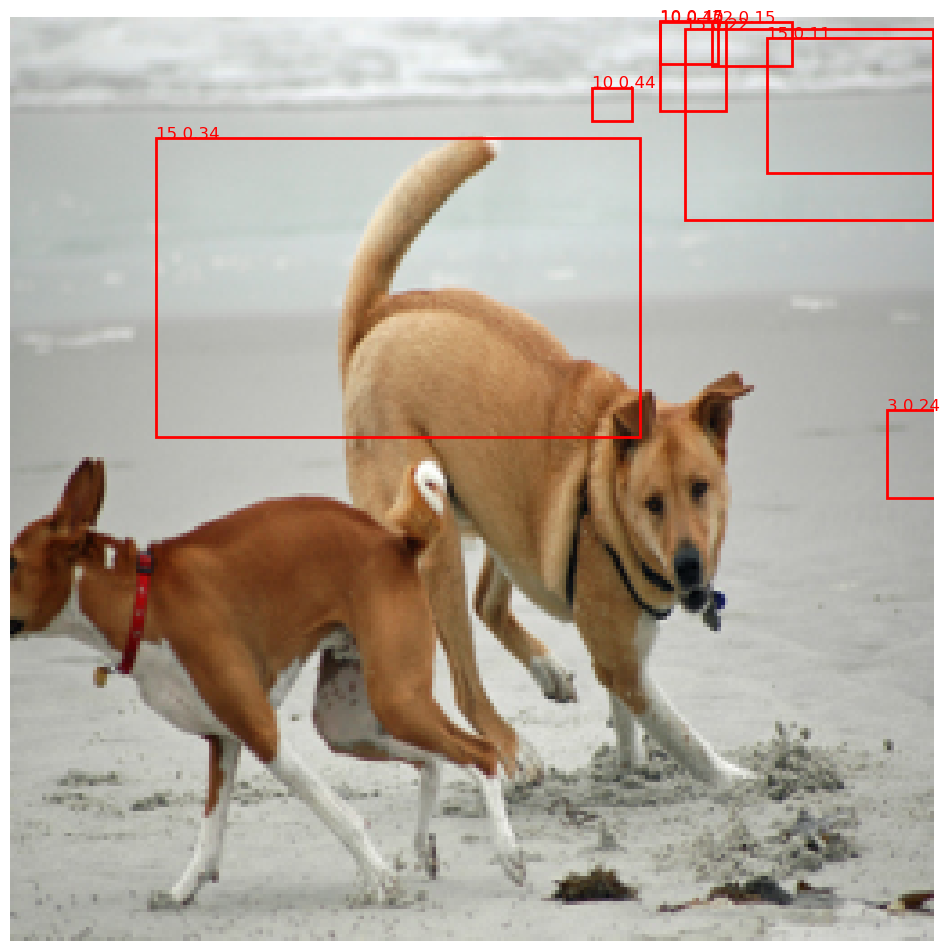

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (193.98915, 57.709667, 203.14415, 73.118546)
box coordinates: (185.84286, 65.153534, 190.37727, 71.55702)
box coordinates: (0.0, 93.51843, 67.95065, 217.6266)
box coordinates: (223.56226, 56.729828, 229.70393, 74.10693)
box coordinates: (242.50018, 62.95887, 254.04077, 70.83725)
box coordinates: (63.240677, 102.75115, 75.00749, 123.04562)
box coordinates: (185.6781, 60.94209, 191.78877, 71.99117)
box coordinates: (186.25816, 56.66054, 204.10788, 74.25686)
box coordinates: (144.31085, 75.015305, 156.7247, 89.62203)
box coordinates: (221.81154, 48.553524, 230.36955, 74.65717)
box coordinates: (209.68912, 60.396797, 218.83931, 83.182724)
box coordinates: (67.02892, 116.52669, 71.076, 122.43801)
box coordinates: (130.9663, 67.72468, 219.38239, 144.40755)


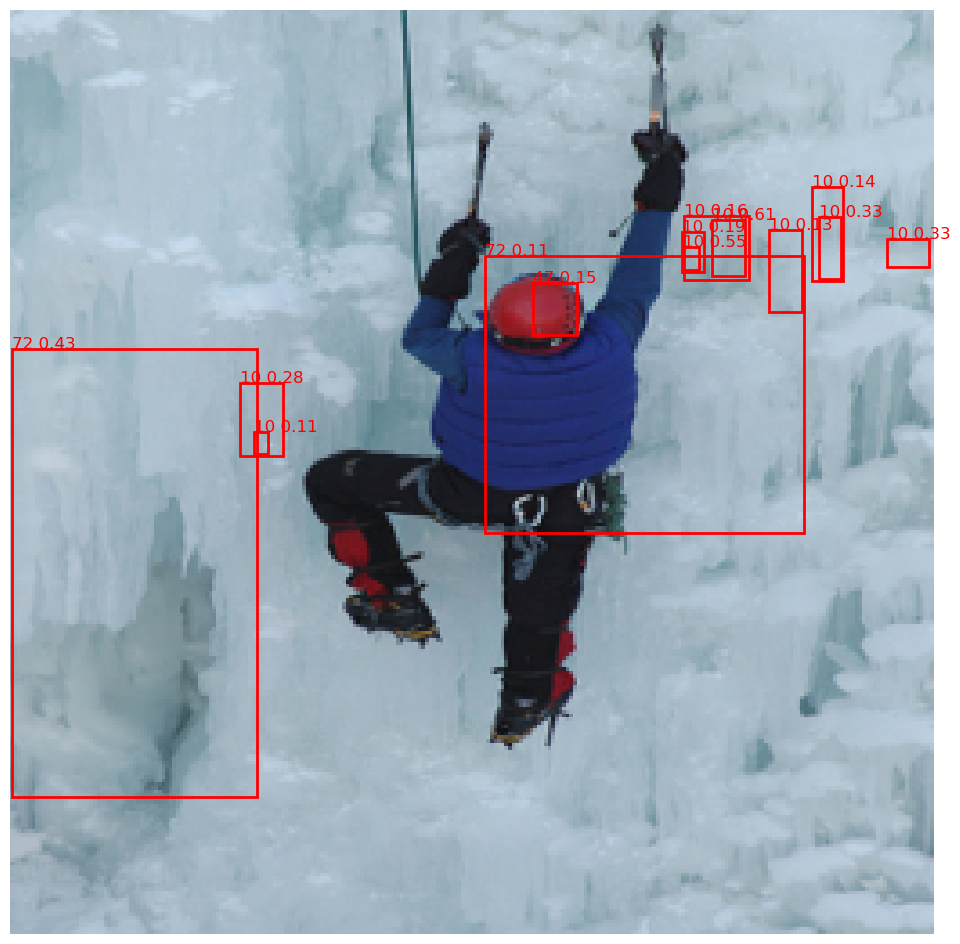

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (117.74726, 22.989214, 142.10458, 80.06556)
box coordinates: (2.946925, 16.320387, 38.03275, 52.339706)
box coordinates: (29.043003, 17.984234, 61.492798, 57.799168)
box coordinates: (105.29293, 241.2825, 141.57835, 256.0)
box coordinates: (80.94519, 238.33469, 113.529335, 256.0)
box coordinates: (177.18726, 240.88652, 206.94061, 255.91812)
box coordinates: (179.3969, 233.98508, 217.26337, 256.0)
box coordinates: (189.1468, 238.17204, 211.51071, 255.79482)
box coordinates: (96.6031, 248.53435, 169.9856, 256.0)
box coordinates: (168.22314, 246.66896, 212.02794, 256.0)


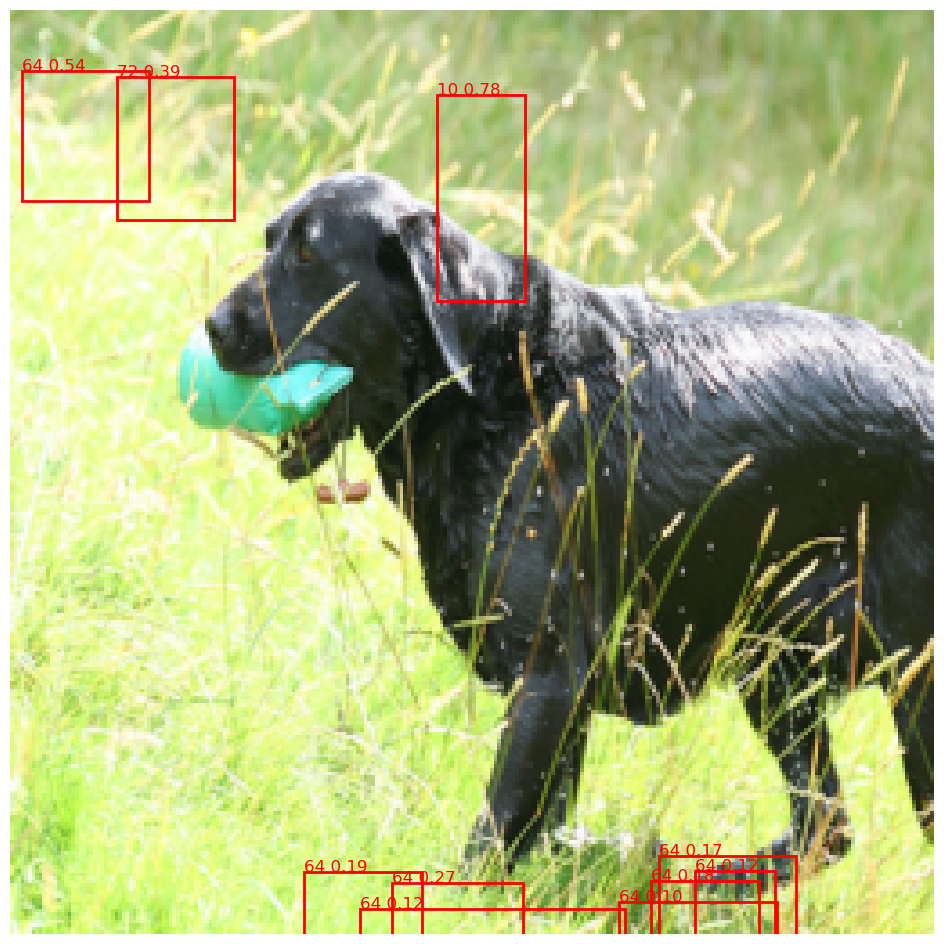

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (131.16147, 223.13026, 141.47162, 241.8189)
box coordinates: (87.401535, 115.45387, 103.93503, 138.51035)
box coordinates: (91.158745, 122.06027, 115.125626, 141.65175)
box coordinates: (91.54575, 163.78354, 98.48268, 174.04576)
box coordinates: (91.593864, 124.06953, 104.28725, 139.16591)
box coordinates: (130.58543, 223.84772, 141.94415, 242.6774)
box coordinates: (85.053535, 111.536766, 110.832535, 141.66904)
box coordinates: (88.38187, 116.776505, 100.3962, 131.2118)
box coordinates: (216.97887, 14.916079, 224.28844, 24.114819)
box coordinates: (74.39265, 159.16916, 86.36331, 169.62286)
box coordinates: (73.90065, 159.11147, 86.76153, 170.04291)
box coordinates: (101.34654, 122.456795, 113.963295, 139.57863)


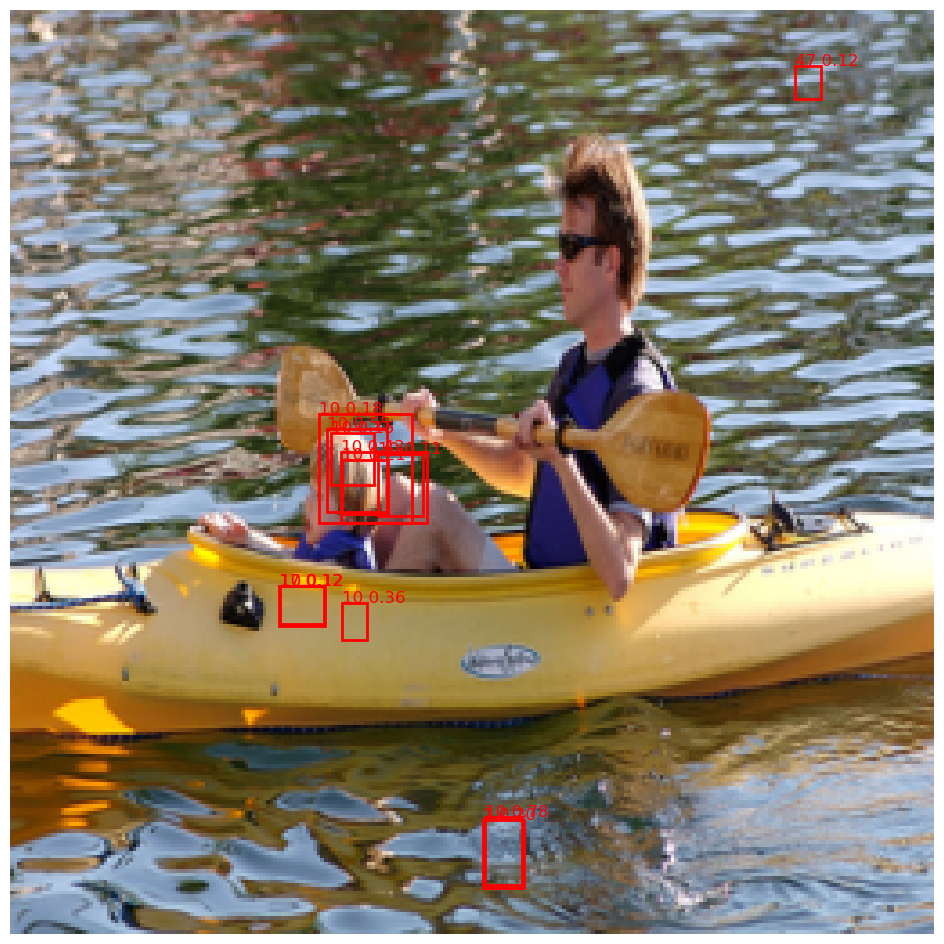

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (108.87229, 21.160536, 157.25932, 110.333954)
box coordinates: (116.00734, 81.70527, 123.24265, 104.40437)
box coordinates: (168.76796, 205.43842, 254.37405, 256.0)
box coordinates: (61.250774, 211.59483, 101.581215, 240.54918)
box coordinates: (111.53146, 23.6524, 154.32144, 100.19022)
box coordinates: (182.3134, 214.61154, 222.11336, 256.0)
box coordinates: (99.41063, 189.76514, 104.277504, 202.58087)
box coordinates: (179.04738, 212.05347, 226.94992, 256.0)
box coordinates: (111.59878, 204.85179, 183.49854, 249.22687)
box coordinates: (191.76755, 243.4207, 201.42665, 256.0)


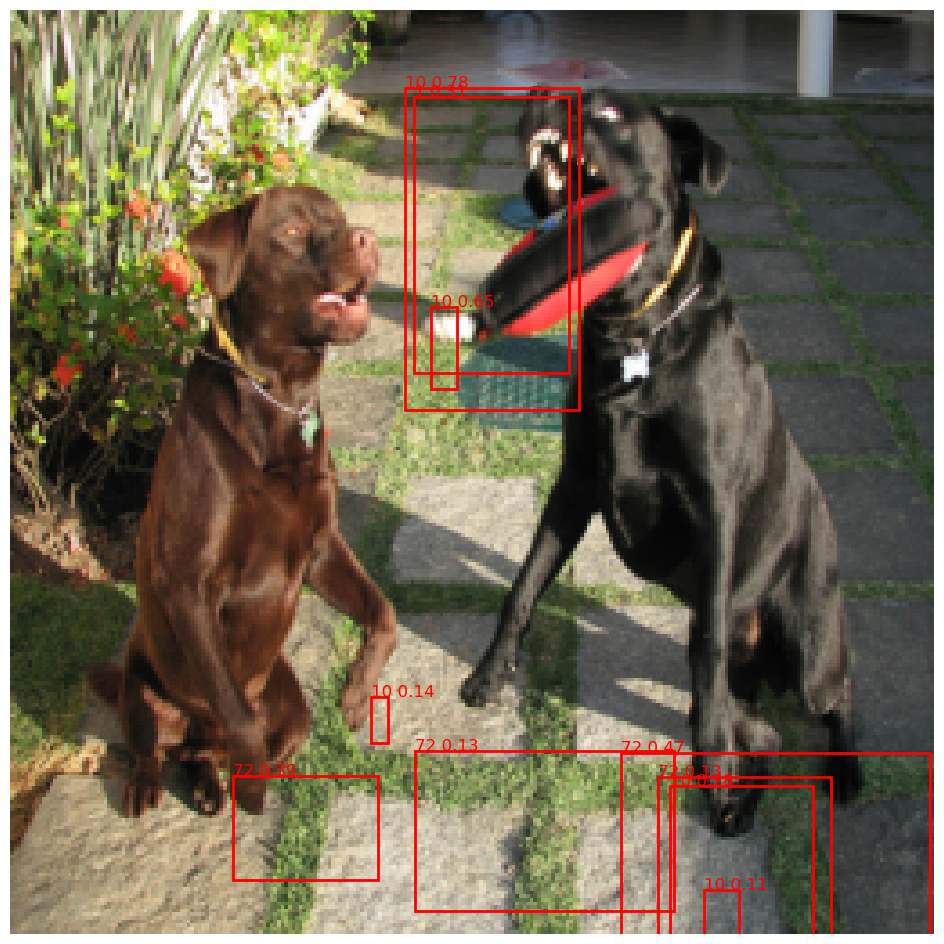

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (110.11457, 5.532665, 119.24086, 16.152416)
box coordinates: (99.46451, 86.79745, 115.74646, 97.55413)
box coordinates: (144.07925, 65.21749, 165.03754, 110.28678)
box coordinates: (5.189514, 47.92272, 13.847061, 60.75787)
box coordinates: (170.89313, 51.04864, 181.69441, 80.72172)
box coordinates: (171.8924, 61.540806, 178.83217, 79.16088)
box coordinates: (97.4093, 85.40692, 119.21475, 120.29581)
box coordinates: (197.1156, 72.09271, 201.90689, 81.85844)
box coordinates: (86.33653, 114.96734, 96.10448, 134.60103)
box coordinates: (116.91706, 191.158, 121.907, 199.21492)
box coordinates: (171.55254, 50.446217, 192.84566, 89.4592)
box coordinates: (176.66124, 32.66787, 192.91624, 51.181545)
box coordinates: (211.91156, 47.49497, 220.38239, 65.29286)
box coordinates: (115.0436, 110.24179, 124.4152, 121.58916)
box coordinates: (172.03296, 51.45963, 181.29262, 63.405693)
bo

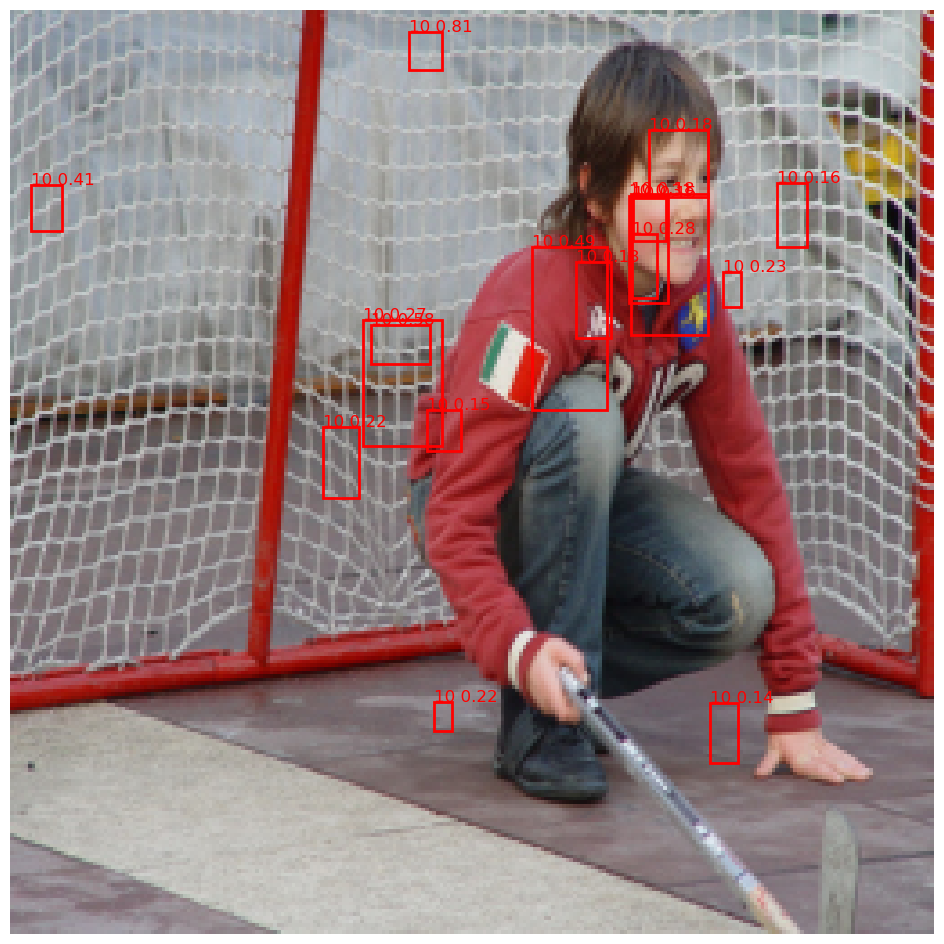

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (31.77078, 65.795296, 48.274128, 87.626755)
box coordinates: (39.049377, 43.211655, 45.797455, 50.907944)
box coordinates: (64.00565, 20.286812, 241.37057, 159.16724)
box coordinates: (44.563526, 4.912953, 62.415134, 40.22832)
box coordinates: (35.77896, 66.34518, 48.36147, 78.367)
box coordinates: (31.692923, 73.239784, 41.234306, 88.07447)
box coordinates: (12.715388, 126.43804, 58.25797, 160.30884)
box coordinates: (20.067627, 65.36111, 27.028652, 75.350464)
box coordinates: (70.59239, 40.62417, 237.47624, 166.25304)
box coordinates: (61.591015, 35.029125, 68.61507, 61.414536)
box coordinates: (13.649306, 126.41861, 61.20063, 158.92372)


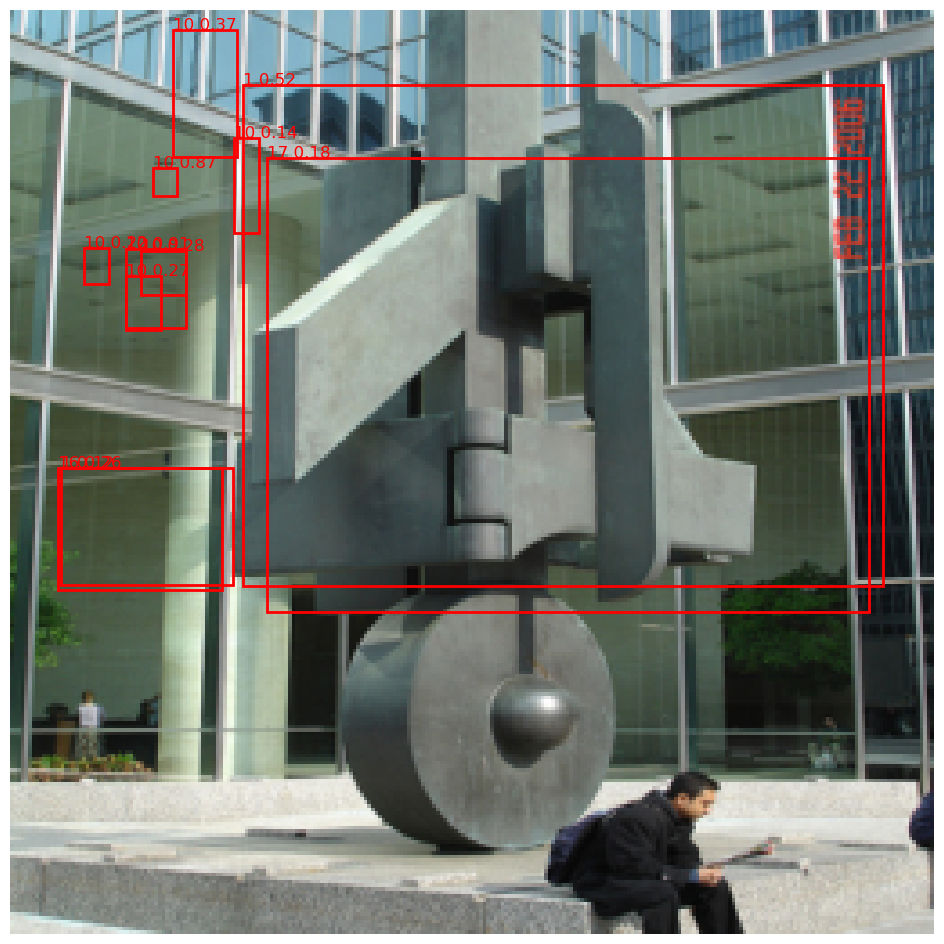

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (102.64285, 135.69373, 240.45601, 256.0)
box coordinates: (168.03922, 202.71515, 225.95491, 254.30757)
box coordinates: (107.05314, 198.29631, 237.68349, 256.0)
box coordinates: (201.31375, 141.3643, 232.32863, 192.37563)
box coordinates: (107.30865, 208.63365, 254.82744, 255.18053)
box coordinates: (162.26408, 44.948746, 212.48975, 80.10745)
box coordinates: (220.78241, 219.25755, 255.75093, 250.1872)
box coordinates: (121.444595, 138.3365, 241.50534, 209.85818)


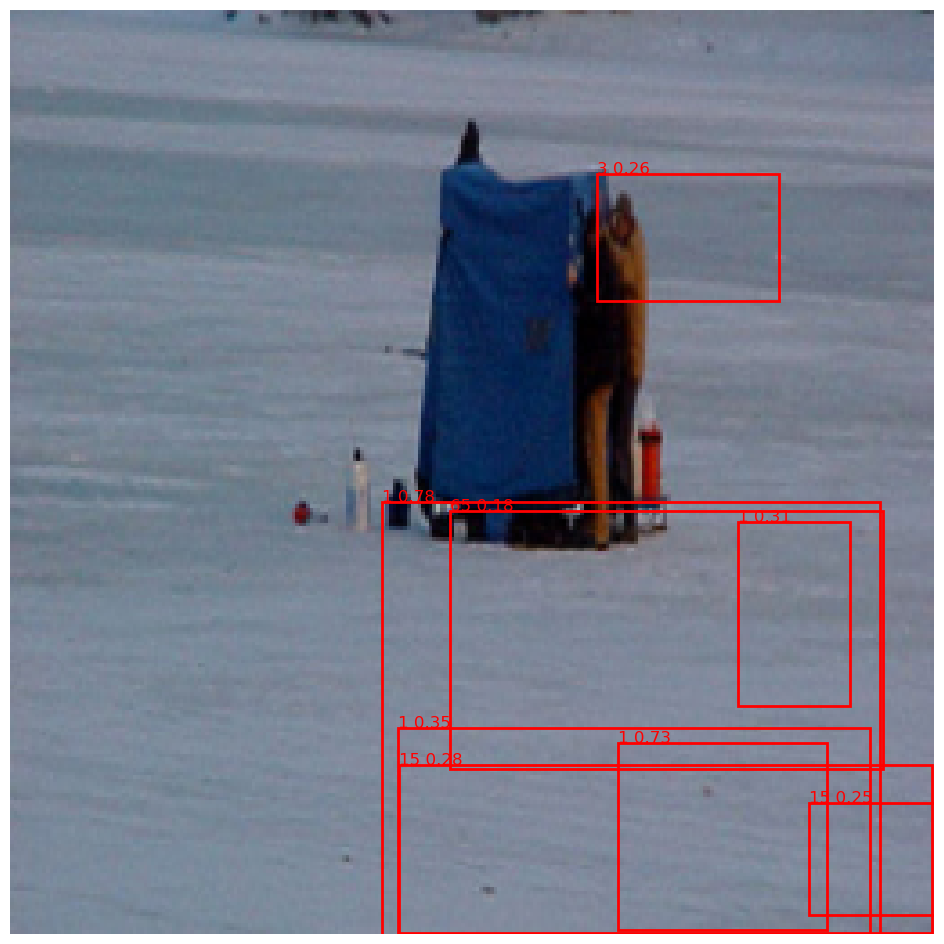

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (55.858994, 22.723402, 128.2912, 110.01402)
box coordinates: (54.61702, 18.84586, 129.76093, 118.12615)
box coordinates: (204.44183, 29.33337, 255.03862, 83.99326)
box coordinates: (200.57791, 31.448185, 254.81146, 83.55664)


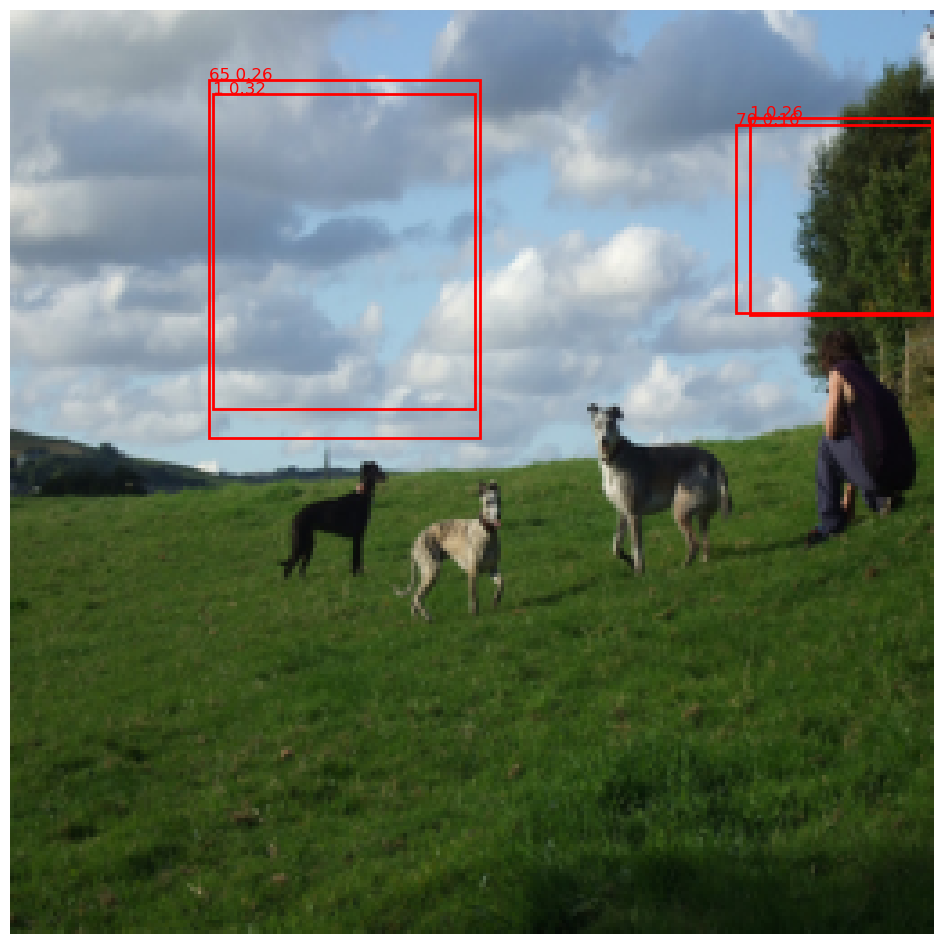

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 29 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (125.06193, 58.695, 134.43256, 82.110275)
box coordinates: (207.95589, 245.70117, 217.62077, 256.0)
box coordinates: (149.4027, 124.25919, 158.2577, 137.93375)
box coordinates: (74.58352, 55.655464, 129.12099, 88.5825)
box coordinates: (193.93584, 250.69379, 200.15276, 256.0)
box coordinates: (77.328224, 53.936913, 93.7589, 76.186905)
box coordinates: (211.05916, 229.8224, 214.71295, 236.3174)
box coordinates: (51.93422, 21.765297, 141.1869, 104.47033)
box coordinates: (194.43005, 223.7024, 204.31985, 228.65115)
box coordinates: (11.362821, 130.77821, 24.393045, 142.0295)


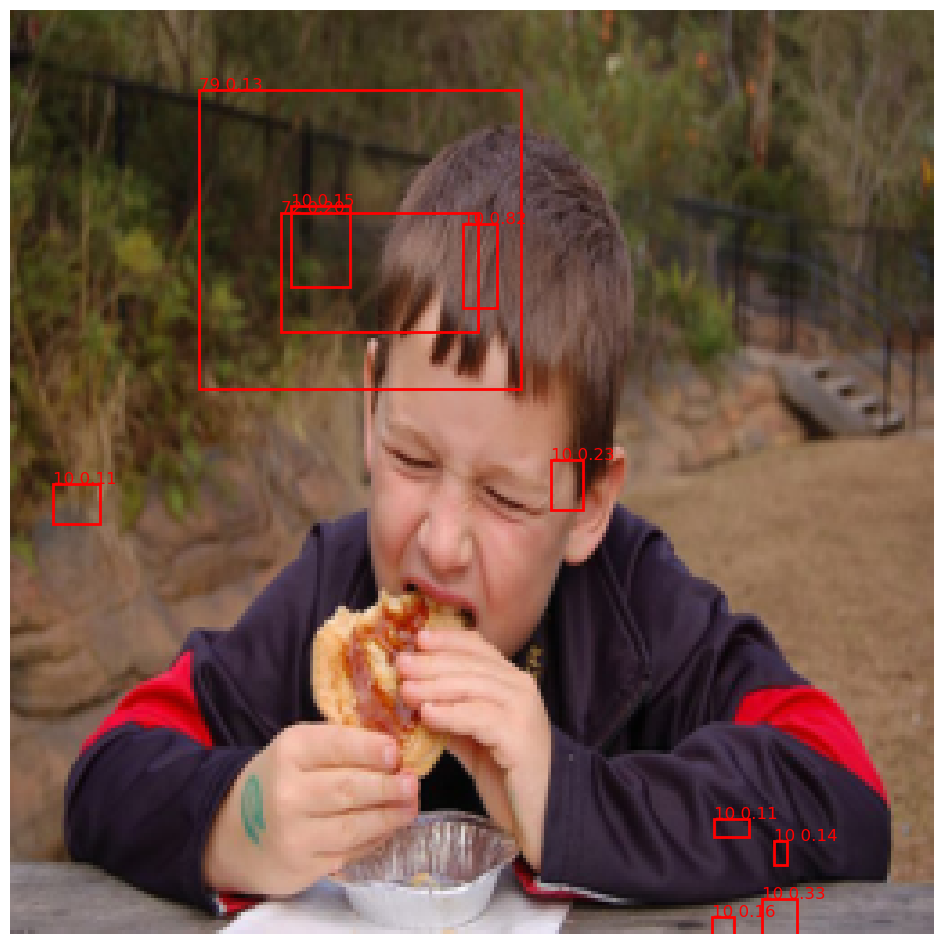

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (245.90292, 113.86821, 256.0, 151.02818)


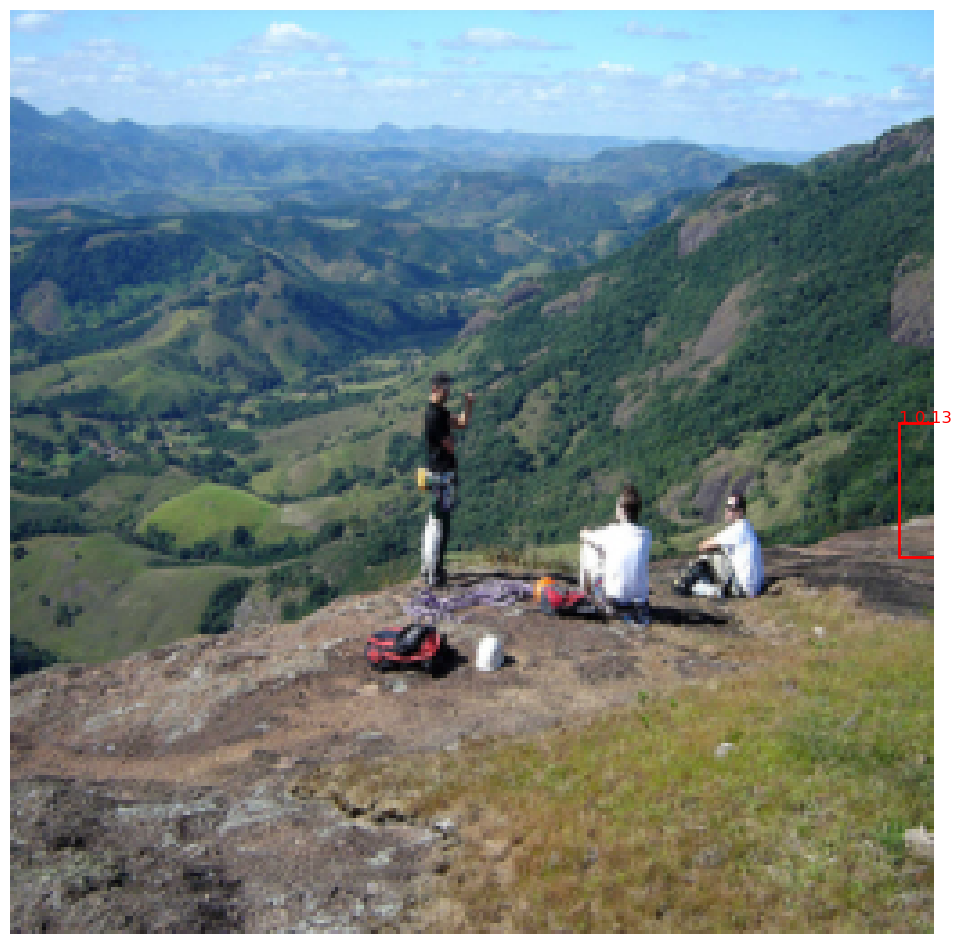

In [3]:
# show some inference results
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def readImage(path, img_size=224):
    transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),  # Converts image to PyTorch Tensor and normalizes between 0 and 1
        ]
    )
    img = Image.open(path).convert("RGB")
    img = transform(img)
    return img.permute(
        1, 2, 0
    ).numpy()  # Permute to (H, W, C) for matplotlib compatibility


def plot_image(image, boxes, labels, scores):
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)
    print(f"dimensions of image {image.shape}")
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        print(f"box coordinates: {x1, y1, x2, y2}")
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=2
        )
        ax.add_patch(rect)
        ax.text(x1, y1, f"{label} {score:.2f}", color="red", fontsize=12)
    plt.axis("off")
    plt.show()


for i, detection in enumerate(detections):
    boxes = detection["boxes"]
    scores = detection["scores"]
    labels = detection["labels"]

    # replace image with the actual image
    print(f"image shape: {images[i].shape}")
    image = readImage(image_dir + "/" + image_names[i], 256)
    print(f"image shape: {image.shape}")
    conf_thresh = 0.1
    keep = scores > conf_thresh  # Filter out low confidence detections
    if keep.sum() == 0:
        print(f"No detections found for image {i} after confidence filtering.")
        continue

    boxes_keep = boxes[keep]
    scores_keep = scores[keep]
    labels_keep = labels[keep]

    # Keep only top 32 scoring predictions
    keep = torch.argsort(scores_keep, descending=True)[:min(32, len(scores_keep))]
    boxes_keep, scores_keep, labels_keep = boxes_keep[keep], scores_keep[keep], labels_keep[keep]
    boxes_keep = boxes_keep.detach().numpy()
    labels_keep = labels_keep.detach().numpy()
    scores_keep = scores_keep.detach().numpy()

    if len(boxes_keep) > 0:
        # Plot the first image with at least one detection
        # image = T.ToPILImage()(image)
        plot_image(image, boxes_keep, labels_keep, scores_keep)
        
    else:
        print(f"No detections found for image {i} after top-k filtering.")


In [13]:
detections[0]

{'boxes': tensor([[  4.9377,  84.6891, 163.9123, 249.7715],
         [  0.0000,   8.5696, 211.9121, 188.6288],
         [  0.0000,  87.3349, 198.6664, 247.2490],
         [123.0402, 240.8983, 147.0703, 255.8129],
         [194.0357, 148.1689, 250.7906, 231.8833],
         [ 44.2410,  37.8075,  57.6249,  49.9493],
         [131.2316,   0.9208, 203.8491, 113.6005]]),
 'labels': tensor([ 1,  3,  3,  1, 70,  1, 10]),
 'scores': tensor([0.0968, 0.0823, 0.0746, 0.0654, 0.0597, 0.0595, 0.0551])}

In [23]:
boxes[0]

tensor([[ 71.1266, 647.8240, 138.6259, 675.9510],
        [ 90.8095, 306.1318, 119.5237, 426.2411],
        [ 73.4191, 647.8556, 136.7758, 674.1085],
        [ 75.5610, 307.6855, 800.0000, 783.4834],
        [ 74.5464, 645.1444, 136.3199, 672.4888],
        [218.0916, 273.9238, 800.0000, 788.4260],
        [239.3088, 266.0416, 798.3476, 800.0000]], grad_fn=<IndexBackward0>)

In [24]:
scores[0]

tensor([0.2232, 0.1970, 0.1865, 0.1143, 0.0810, 0.0558, 0.0514],
       grad_fn=<IndexBackward0>)

In [25]:
labels[0]

tensor([ 3, 10, 81,  3, 51,  2, 70])

In [6]:
box_features[0].shape

torch.Size([1024])

In [8]:
box_features.shape

torch.Size([32000, 1024])